In [6]:
import os
import glob
import h5py
import fitsio
import healpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from iminuit import Minuit
import scipy as sp
import scipy.stats
import scipy.constants
from scipy.interpolate import interp1d
import copy

from picca import wedgize

#%matplotlib inline
rcParams['figure.figsize'] = 10, 6
rcParams['lines.linewidth'] = 4
rcParams['axes.labelsize'] = 20
rcParams['legend.fontsize'] = 20
#plt.rc('text',usetex=True)

## __Which mocks__

In [7]:
### Get mocks
mock = {}
mock['nbReal'] = 10
mock['team'] = 'london'
mock['mock_ver'] = 'v4.0.<*>'
mock['quick_ver'] = 'quick-2.0'
mock['mock_base'] = '/global/projecta/projectdirs/desi/mocks/lya_forest/'+mock['team']+'/'+mock['mock_ver']+'/'
mock['picca'] = '/project/projectdirs/desi/mocks/lya_forest/picca/'+mock['team']+'/'+mock['mock_ver']+'/'+mock['quick_ver']

Redshift bins

In [8]:
#zint = ['0:2.2','2.2:2.4','2.4:2.6','2.6:2.8','2.8:3.0','3.0:3.2','3.2:10','0:10']
zint = ['0:10']

## __Look at fit results__

In [9]:
toPlot = {}

In [10]:
### Mocks
for idx in range(mock['nbReal']):
    path = mock['picca'].replace('<*>',str(idx))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            toPlot['{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)] = {
                'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
                'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
                'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
                'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

In [11]:
### Mocks stacked
path = mock['picca'].replace('<*>','all')
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]
    for cor in ['cf','xcf','cfxcf']:
        toPlot['{}-Mock-{}-z-{}-{}'.format('all',cor,zmin,zmax)] = {
            'CORR':path+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax),
            'FIT':path+'/{}_z_{}_{}-exp.h5'.format(cor,zmin,zmax),
            'NAME':'{}_z_{}_{}-exp'.format(cor,zmin,zmax),
            'TITLE':'{}-z-{}-{}'.format(cor,zmin,zmax)}

Load the fit results

In [12]:
for name,paths in sorted(toPlot.items()):

    ### Exist?
    if not os.path.isfile(os.path.expandvars(paths['FIT'])):
        print(' WARNING: does not exist ', paths['FIT'])
        continue

    ### Covar matrix is possitive definite
    if not 'cfxcf' in toPlot[name]['CORR']:
        h = fitsio.FITS(toPlot[name]['CORR'])
        try:
            sp.linalg.cholesky(h[1]['CO'][:])
            print('ok: ', name)
        except sp.linalg.LinAlgError:
            print('not ok', name)
            continue
        h.close()
    
    f = h5py.File(os.path.expandvars(paths['FIT']),'r')
    toPlot[name]['FIT_RES'] = {}
    toPlot[name]['FIT_RES']['ZEFF'] = f['best fit'].attrs['zeff']
    for k in list(f['best fit'].attrs['list of free pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in list(f['best fit'].attrs['list of fixed pars']):
        toPlot[name]['FIT_RES'][k.decode("utf-8") ] = f['best fit'].attrs[k]
    for k in ['fval','is_valid','npar','ndata']:
        toPlot[name]['FIT_RES'][k] = f['best fit'].attrs[k]
    if not toPlot[name]['FIT_RES']['is_valid']:
        print(toPlot[name]['FIT_RES']['is_valid'])
    p = 1.-sp.stats.chi2.cdf(toPlot[name]['FIT_RES']['fval'],toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar'])
    toPlot[name]['FIT_RES']['proba'] = p
    f.close()

ok:  0-Mock-cf-z-0-10
ok:  0-Mock-xcf-z-0-10
ok:  1-Mock-cf-z-0-10
ok:  1-Mock-xcf-z-0-10
ok:  2-Mock-cf-z-0-10
ok:  2-Mock-xcf-z-0-10
ok:  3-Mock-cf-z-0-10
ok:  3-Mock-xcf-z-0-10
ok:  4-Mock-cf-z-0-10
ok:  4-Mock-xcf-z-0-10
ok:  5-Mock-cf-z-0-10
ok:  5-Mock-xcf-z-0-10
ok:  6-Mock-cf-z-0-10
ok:  6-Mock-xcf-z-0-10
ok:  7-Mock-cf-z-0-10
ok:  7-Mock-xcf-z-0-10
ok:  8-Mock-cf-z-0-10
ok:  8-Mock-xcf-z-0-10
ok:  9-Mock-cf-z-0-10
ok:  9-Mock-xcf-z-0-10
ok:  all-Mock-cf-z-0-10
ok:  all-Mock-xcf-z-0-10


### Chi2 and probability as a function of mock index

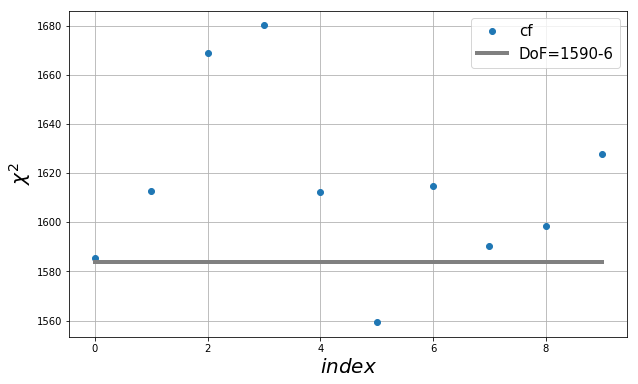

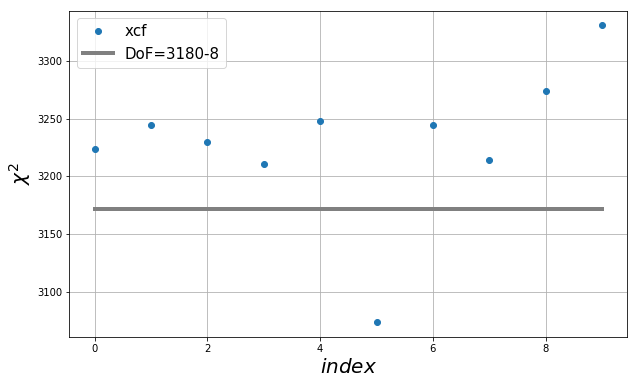

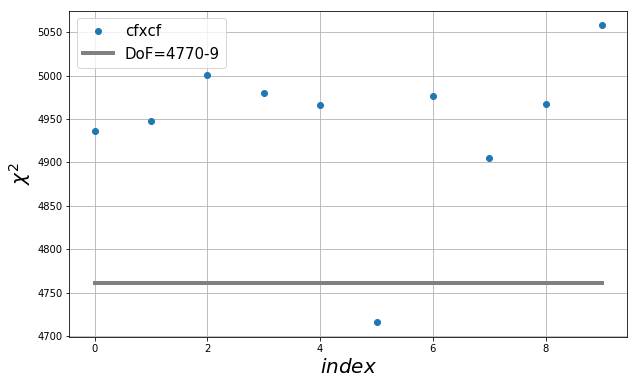

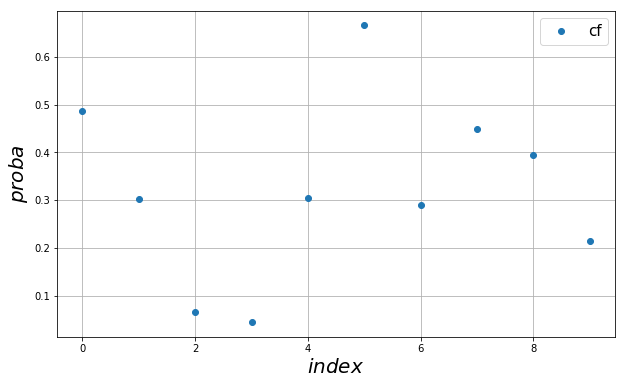

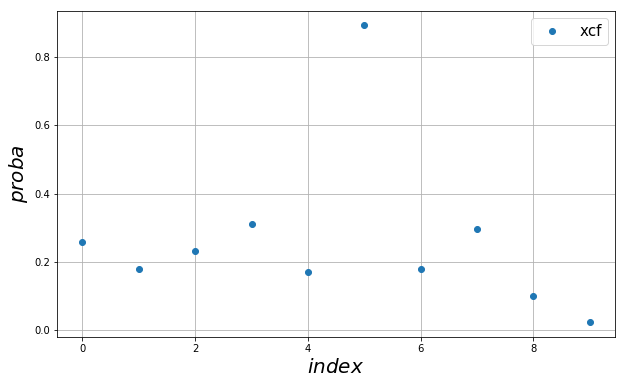

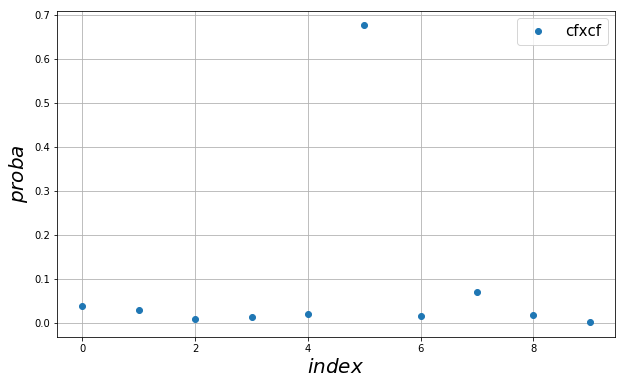

In [13]:
latexnameProba = {'fval':'\chi^{2}',
             'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yyy[w],fmt='o',label=cor)
            if p=='fval':
                if (exp[w]==exp[w][0]).sum()!=exp[w].size:
                    print(exp[w])
                plt.errorbar(xxx[w],exp[w],linewidth=4,color='grey',label='DoF={}-{}'.format(int(ndata[w][0]),int(npar[w][0])))

            plt.xlabel(r'$index$')
            plt.ylabel(r'$'+latexnameProba[p]+'$')
            plt.legend(fontsize=15)
            plt.grid()
            plt.show()

### Histogram of Chi2 and probability

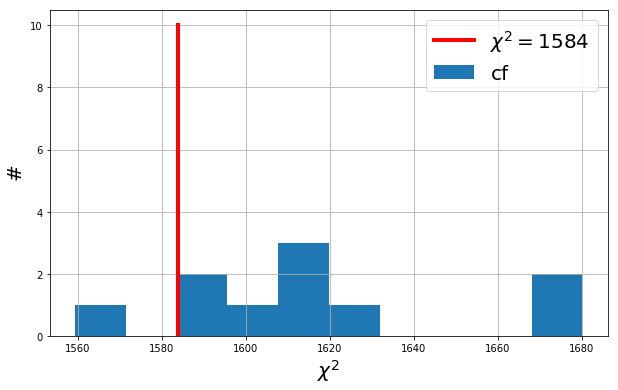

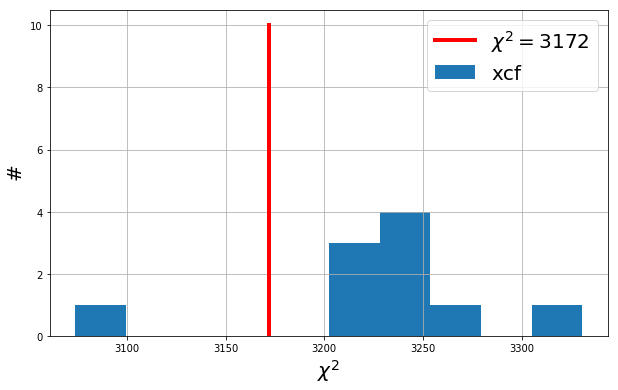

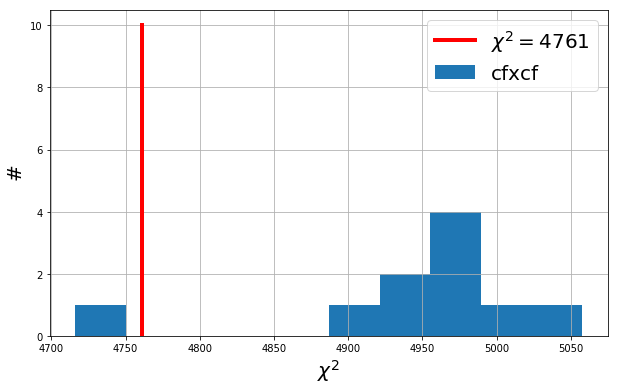

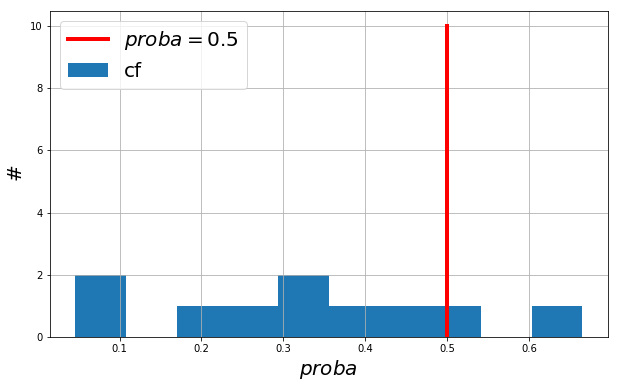

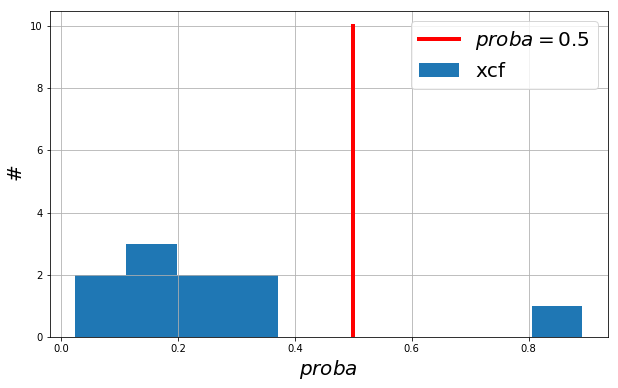

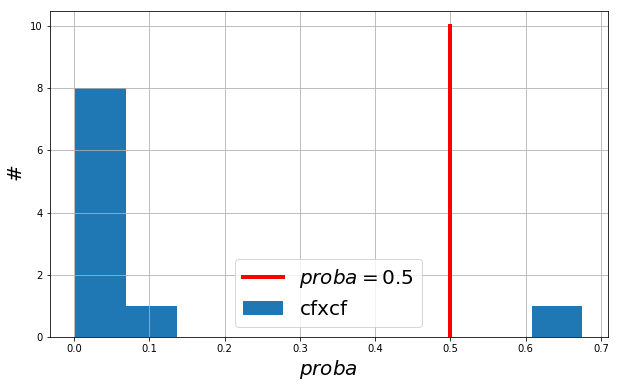

In [14]:
latexnameProba = {'fval':'\chi^{2}',
                'proba':'proba',}
for p in latexnameProba.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]

        for cor in ['cf','xcf','cfxcf']:
            
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            exp = sp.zeros(mock['nbReal'])
            ndata = sp.zeros(mock['nbReal'])
            npar = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p]
                    exp[idx] = toPlot[name]['FIT_RES']['ndata']-toPlot[name]['FIT_RES']['npar']
                    ndata[idx] = toPlot[name]['FIT_RES']['ndata']
                    npar[idx] = toPlot[name]['FIT_RES']['npar']
            w = exp>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,label=cor)
            if p=='fval':
                plt.plot([exp[0],exp[0]],[0.,10.],color='red',label=r'$\chi^{2}='+str(int(exp[0]))+'$')
            elif p=='proba':
                plt.plot([0.5,0.5],[0.,10.],color='red',label=r'$proba={}$'.format(0.5))
            plt.xlabel(r'$'+latexnameProba[p]+'$')
            plt.ylabel(r'$\#$')
            plt.legend()
            plt.grid()
            plt.show()

### Parameters

In [15]:
latexname = {'ap':'\\alpha_{\parallel}',
             'at':'\\alpha_{\perp}',
             'bias_LYA' : 'b_{\\eta,\mathrm{Ly}\\alpha}',
             'beta_LYA' : '\\beta_{\mathrm{Ly}\\alpha}',
             'beta_QSO' : '\\beta_{\mathrm{qso}}',
             'sigma_velo_lorentz':'\sigma_{v}\,[\mathrm{h^{-1}\,Mpc}]',
             'drp':'\Delta r_{\parallel}\,[\mathrm{h^{-1}\,Mpc}]',
             #'par binsize cf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize cf_z_0_10-exp': 'R_{\\perp}',
             #'par binsize xcf_z_0_10-exp': 'R_{\\parallel}',
             #'per binsize xcf_z_0_10-exp': 'R_{\\perp}',
             'par_sigma_smooth': 'par-sigma-smooth',
             'per_sigma_smooth': 'per-sigma-smooth',
            }
expected = {'ap':1.,
             'at':1.,
             'bias_LYA' : None,
             'beta_LYA' : None,
             'beta_QSO' : None,
             'sigma_velo_lorentz':None,
             'drp':0.,
             #'par binsize cf_z_0_10-exp': None,
             #'per binsize cf_z_0_10-exp': None,
             #'par binsize xcf_z_0_10-exp': None,
             #'per binsize xcf_z_0_10-exp': None,
             'par_sigma_smooth': None,
             'per_sigma_smooth': None,
            }

### The parameters as a function of mock index

cf: <ap> = 1.0058406580324182 +/- 0.004115548283794686 (<0.018484009239768562>, 0.005845156948926603)
xcf: <ap> = 1.006591019230238 +/- 0.0038599480705274547 (<0.01668456292822551>, 0.005276122061760105)
cfxcf: <ap> = 1.0074457266087262 +/- 0.003151793625355474 (<0.012302405379947572>, 0.003890362169934349)


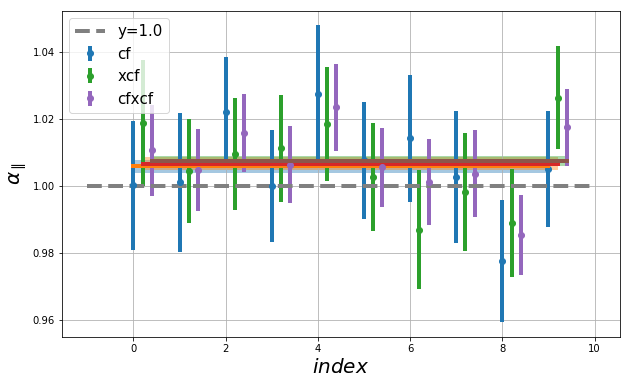

cf: <at> = 1.0124888291400285 +/- 0.005224107217124778 (<0.026898677978139635>, 0.00850610884583341)
xcf: <at> = 0.9962947129512696 +/- 0.003153753305340926 (<0.017846093571317622>, 0.005643430302185224)
cfxcf: <at> = 1.0007214913716378 +/- 0.0027610895474655135 (<0.014750735489015076>, 0.004664592130796527)


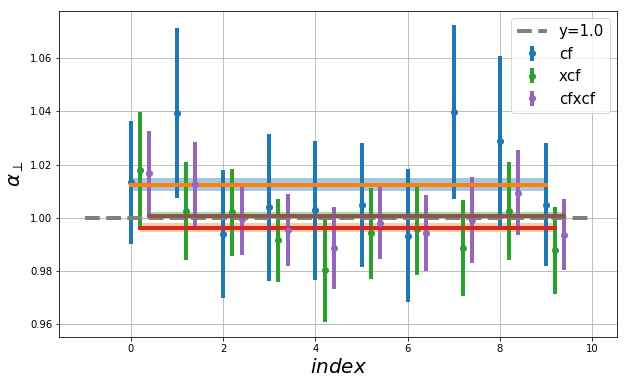

cf: <bias_LYA> = -0.1514183583530116 +/- 0.0004095023483411531 (<0.0014244462231013052>, 0.00045044944694244807)
xcf: <bias_LYA> = -0.1516311012237613 +/- 0.0009232854075282067 (<0.0026740256999244955>, 0.0008456011733587346)
cfxcf: <bias_LYA> = -0.14962950736462333 +/- 0.0002985122559302969 (<0.001160364756143034>, 0.0003669395545997845)


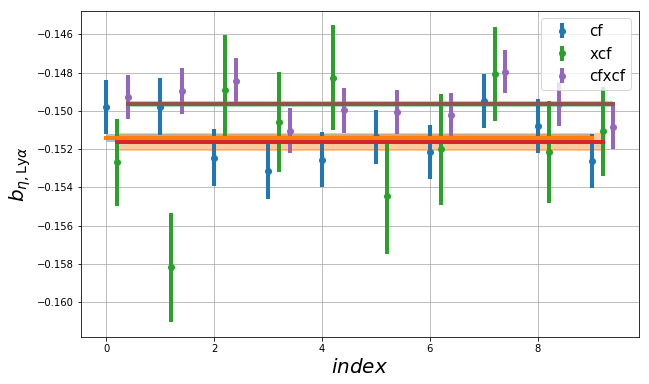

cf: <beta_LYA> = 1.40623886797562 +/- 0.006740546518876097 (<0.023989131059588054>, 0.00758602932365867)
xcf: <beta_LYA> = 1.4192588017427155 +/- 0.015529549676552016 (<0.041628378701200994>, 0.013164049199583706)
cfxcf: <beta_LYA> = 1.390721426692861 +/- 0.006188089820545575 (<0.01929315423450708>, 0.006101031062996471)


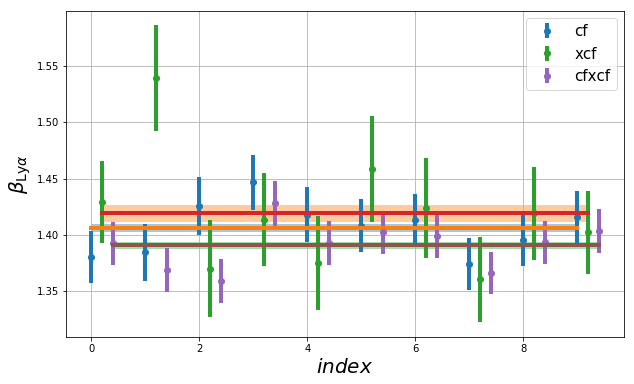

cfxcf: <beta_QSO> = 0.2575006389760431 +/- 0.0005323778150558956 (<0.0013019005076798657>, 0.00041169708911979107)


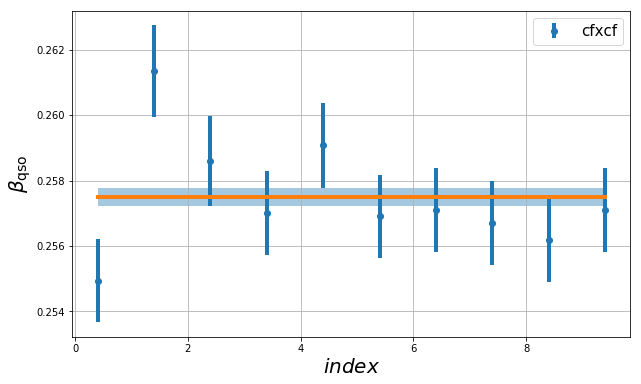

xcf: <sigma_velo_lorentz> = 1.6844170553044073 +/- 0.22624897440180253 (<1.0361624836838652>, 0.32766334744580694)
cfxcf: <sigma_velo_lorentz> = 0.00013910672650969386 +/- 3.2209777905564626e-05 (<0.15423416175254673>, 0.04877312441448748)


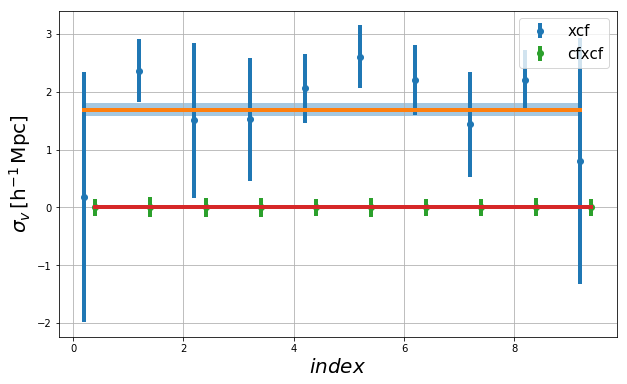

xcf: <drp> = 0.05196491263250623 +/- 0.01178109032980076 (<0.033211813652297195>, 0.01050249763663346)
cfxcf: <drp> = 0.048421090660925245 +/- 0.011717783531773659 (<0.03275674134191063>, 0.010358591136543796)


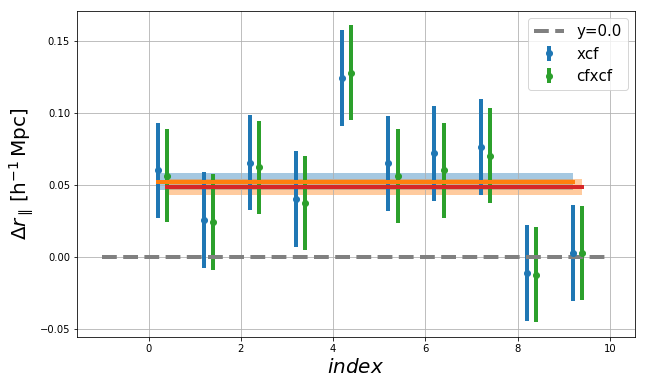

cf: <par_sigma_smooth> = 3.160024888158833 +/- 0.014853518326577036 (<0.057887613518608806>, 0.018305670703035768)
xcf: <par_sigma_smooth> = 1.5263516603740894 +/- 0.15926281812120152 (<0.8091216886540499>, 0.2558667440388417)
cfxcf: <par_sigma_smooth> = 2.7985534723745356 +/- 0.0183869568552099 (<0.04624838973179934>, 0.01462502496676297)


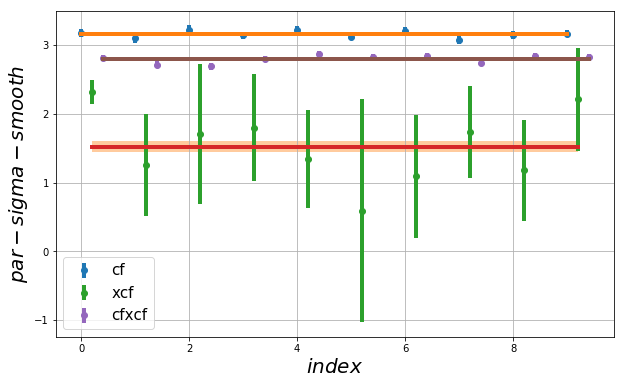

cf: <per_sigma_smooth> = 3.5198112521811424 +/- 0.07350889384743911 (<0.10067538621612955>, 0.031836352476009)
xcf: <per_sigma_smooth> = 3.299936237410266 +/- 0.014142635564938605 (<0.10237270073504261>, 0.032373090454552826)
cfxcf: <per_sigma_smooth> = 3.5041154804687764 +/- 0.02044273278853759 (<0.06178689564605507>, 0.019538731979267483)


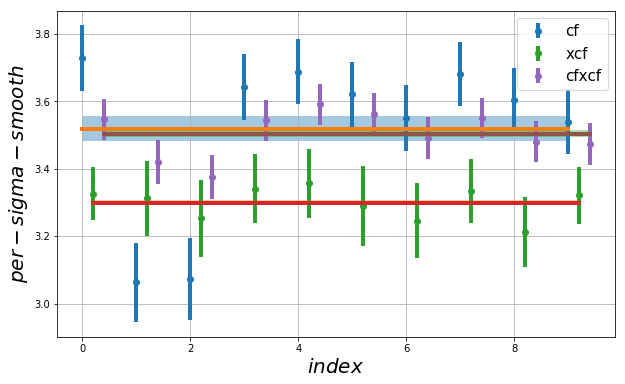

In [16]:
for p in latexname.keys():
    if not expected[p] is None:
        plt.plot(sp.arange(mock['nbReal']+2)-1.,expected[p]*sp.ones(mock['nbReal']+2),
                 '--',linewidth=4,color='grey',label='y={}'.format(expected[p]))
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            if p=='sigma_velo_lorentz': yyy = sp.absolute(yyy)
            w = yer>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yyy[w],yerr=yer[w],fmt='o',label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
            print('{}: <{}> = {} +/- {} (<{}>, {})'.format(cor, p,mean,err,meanErr,meanErr/sp.sqrt(yyy[w].size)))
            plt.errorbar(xxx,mean*sp.ones(xxx.size))
            plt.fill_between( xxx, mean*sp.ones(xxx.size)-err/2., mean*sp.ones(xxx.size)+err/2.,alpha=0.4)
    plt.xlabel(r'$index$')
    plt.ylabel(r'$'+latexname[p]+'$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The error as a function of mock index

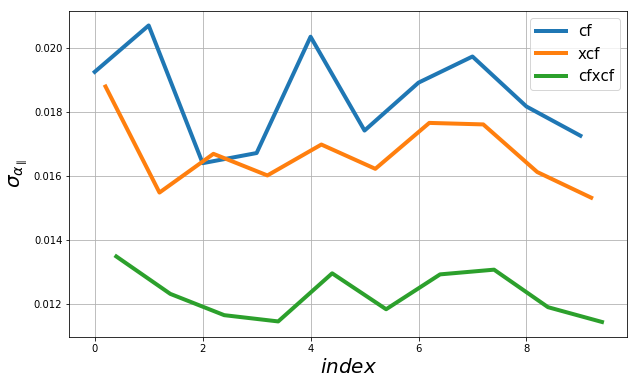

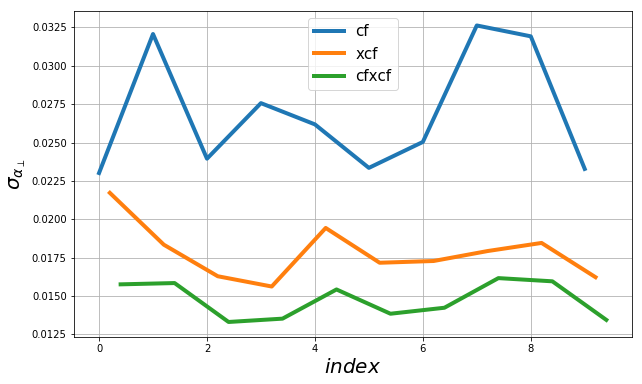

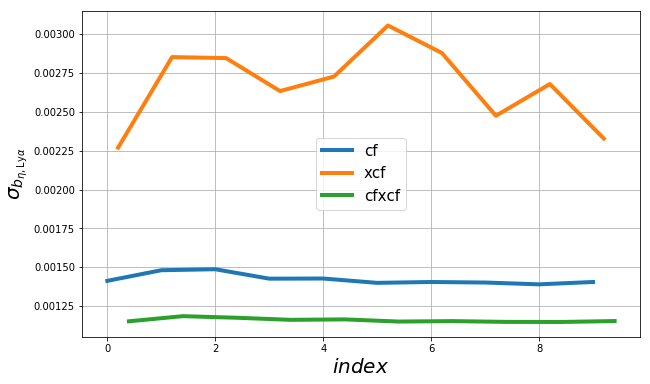

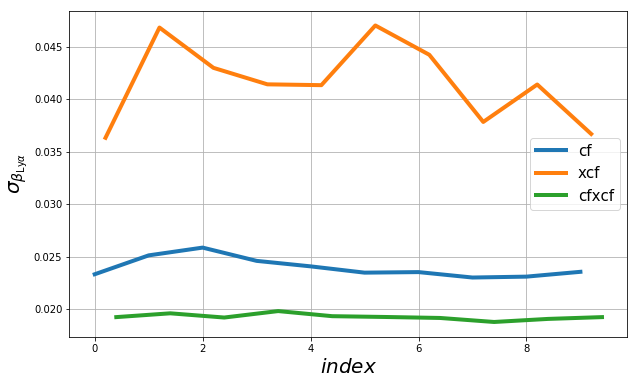

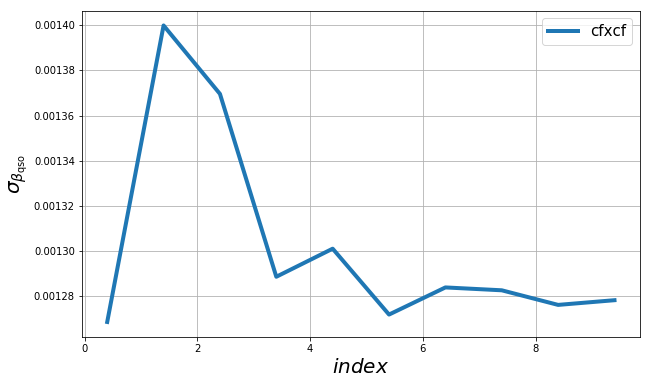

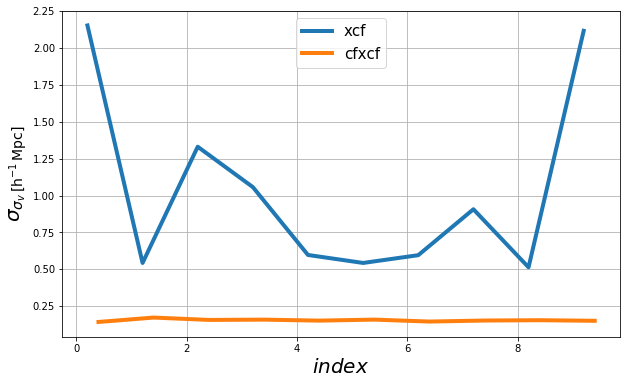

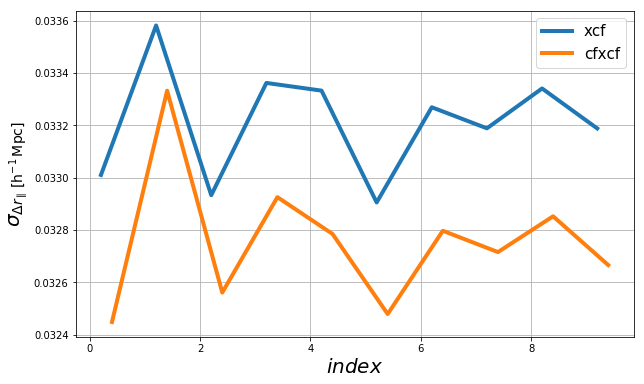

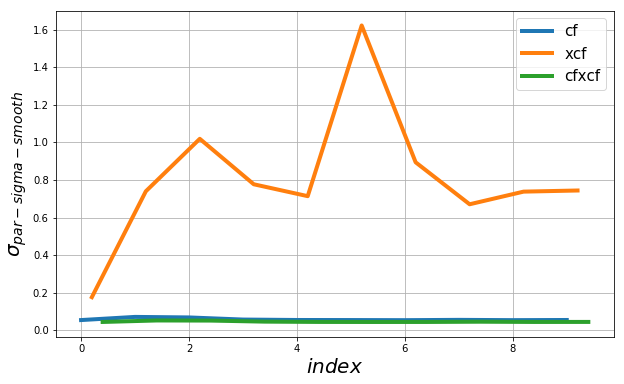

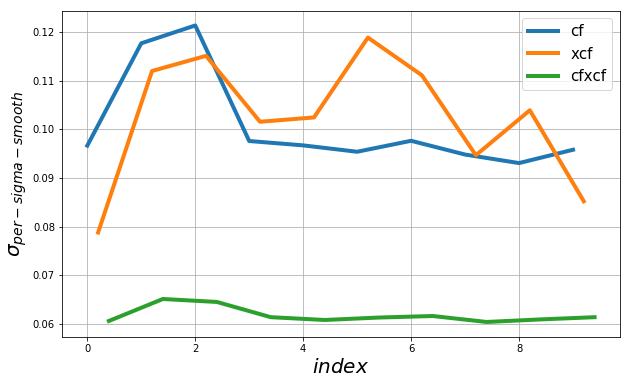

In [17]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf': xxx += 0.2
            if cor=='cfxcf': xxx += 0.4
            w = yer>0.
            if w.sum()==0: continue
            plt.errorbar(xxx[w],yer[w],label=cor)
    plt.xlabel(r'$index$')
    plt.ylabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The histograms of the parameters

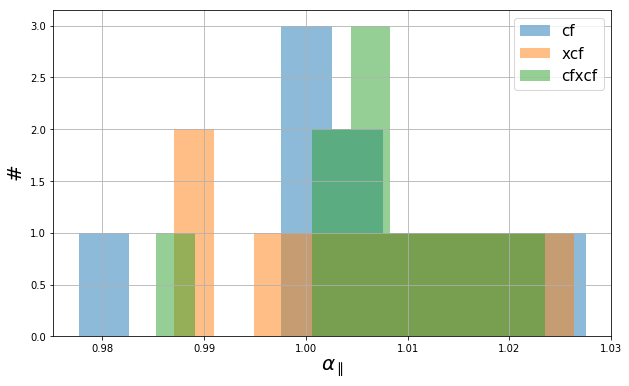

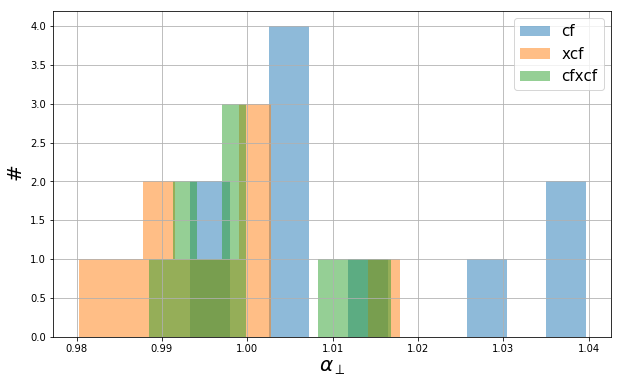

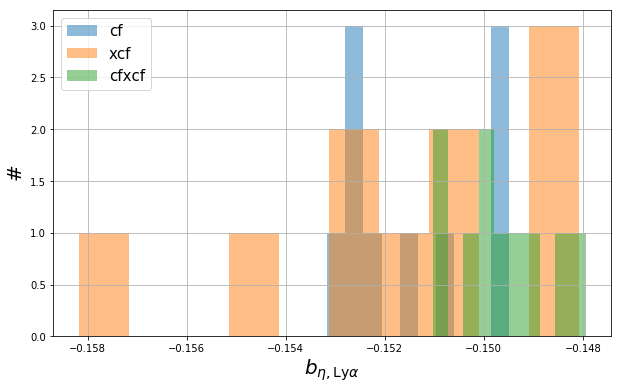

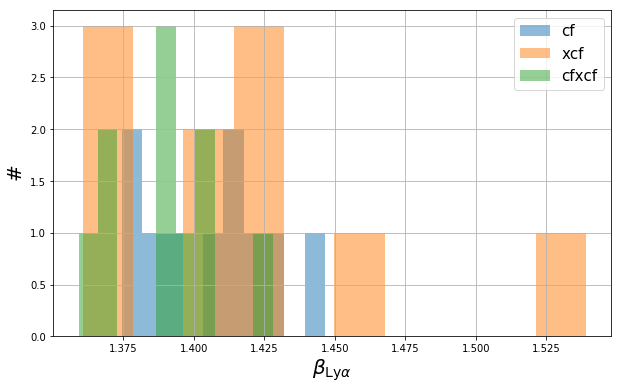

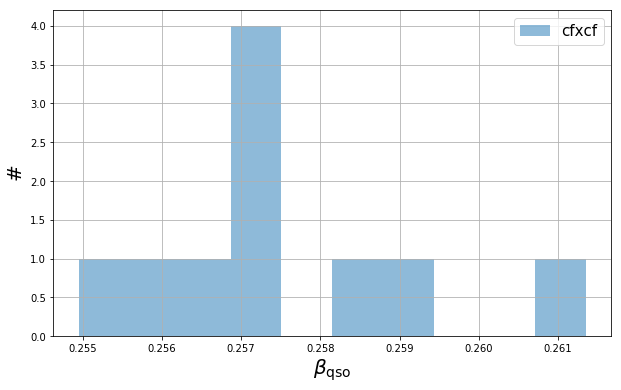

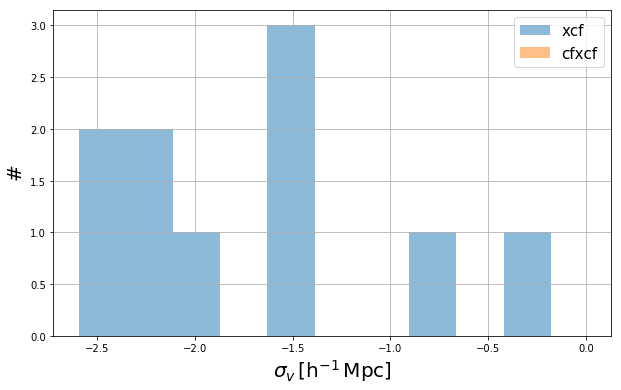

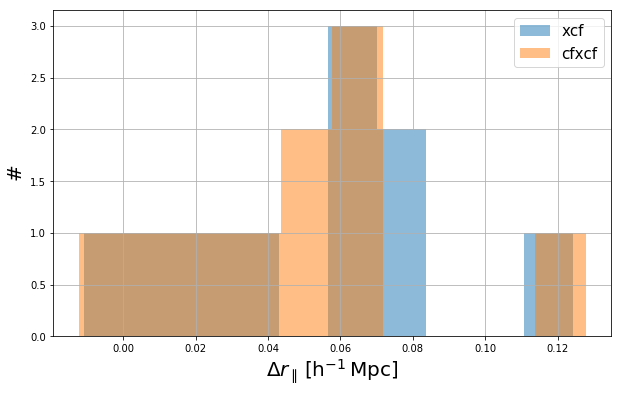

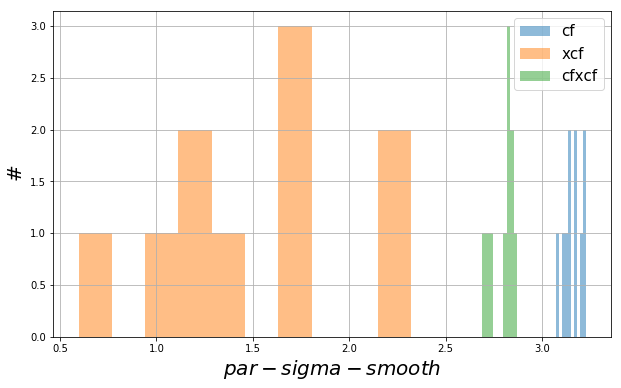

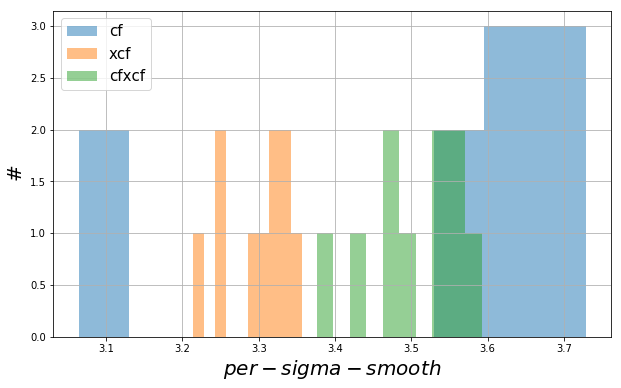

In [18]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yyy[w],bins=10,alpha=0.5,label=cor)
            mean = yyy[w].mean()
            err = yyy[w].std()/sp.sqrt(yyy[w].size)
            meanErr = yer[w].mean()
    plt.xlabel(r'$'+latexname[p]+'$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Histogram of the errors

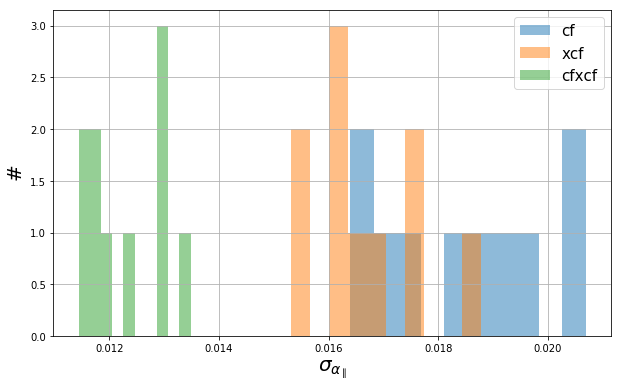

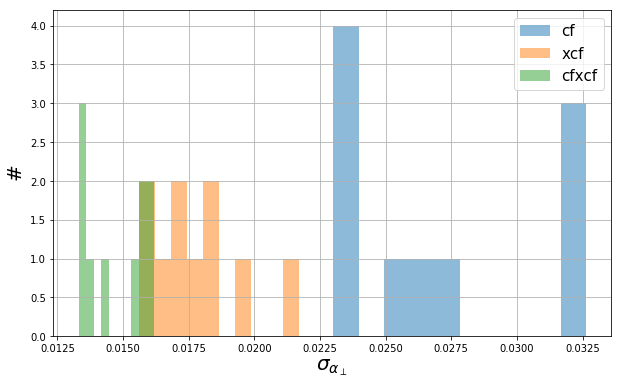

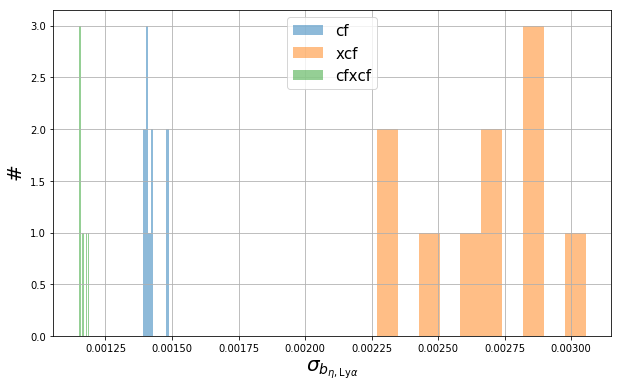

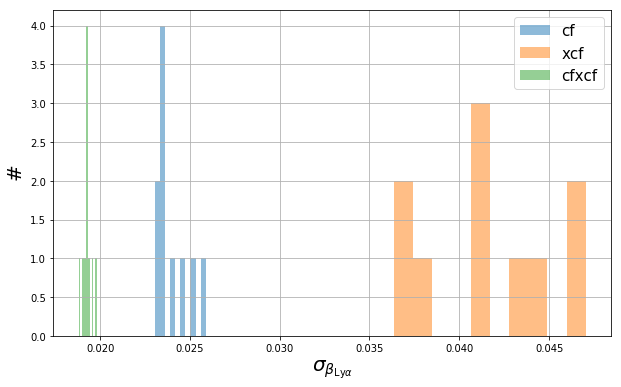

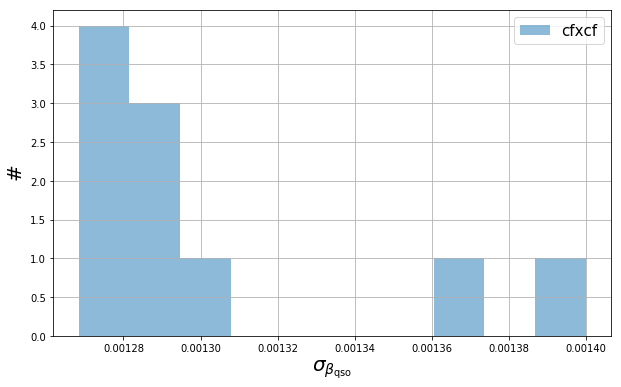

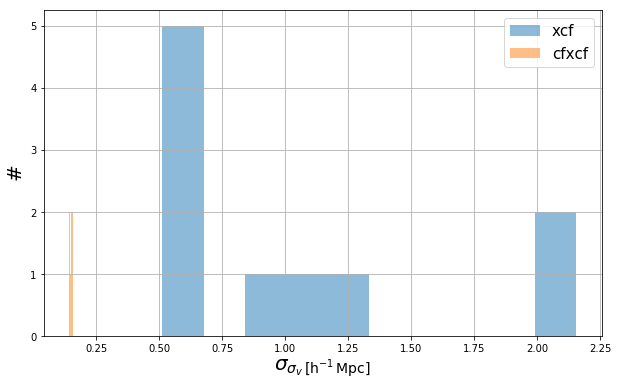

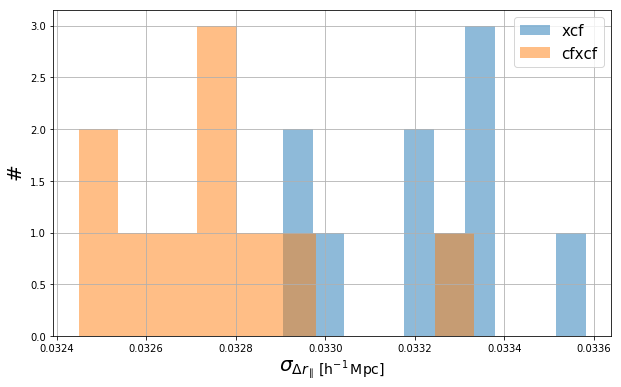

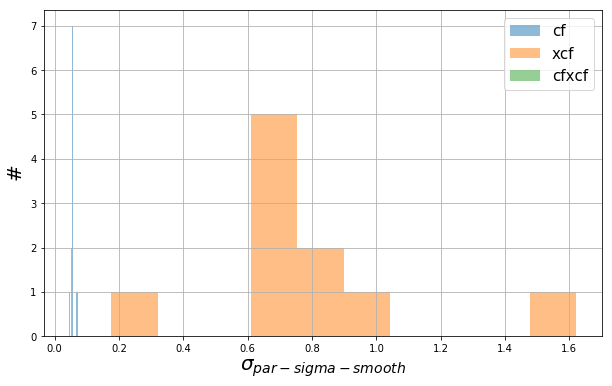

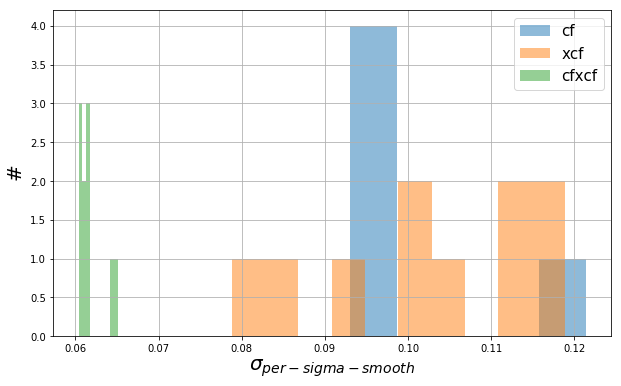

In [19]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist(yer[w],bins=10,alpha=0.5,label=cor)
    plt.xlabel(r'$\sigma_{'+latexname[p]+'}$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### The pull plots of the parameters

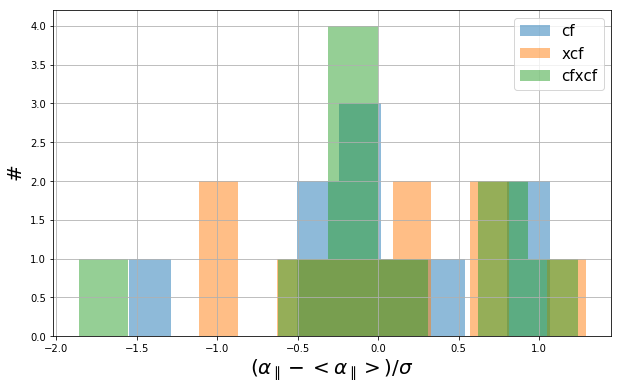

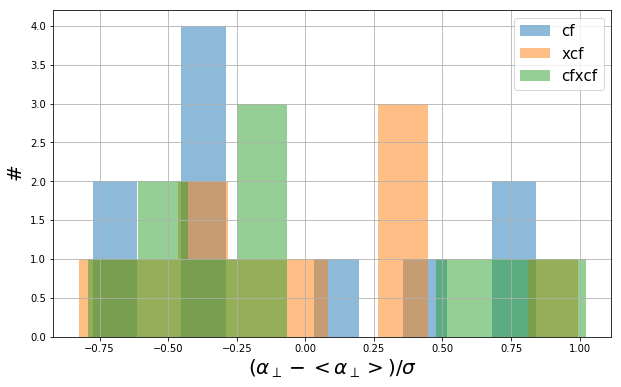

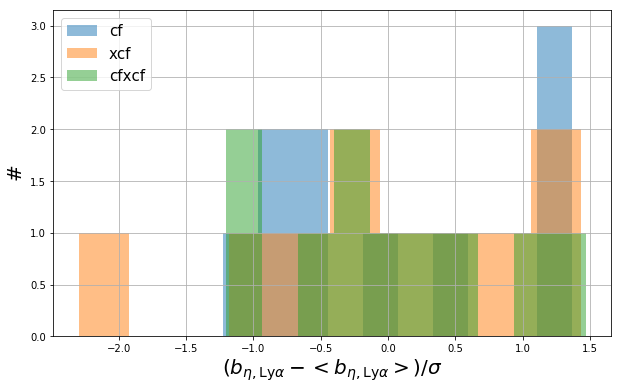

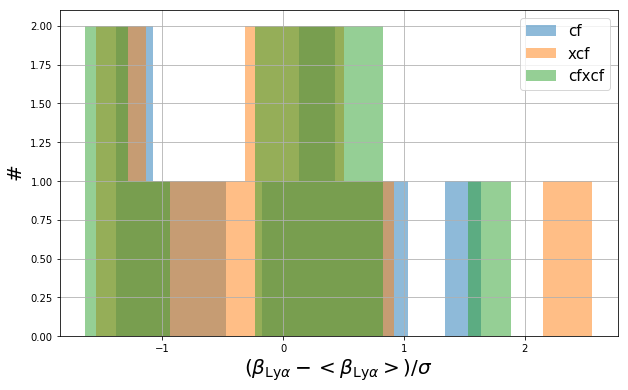

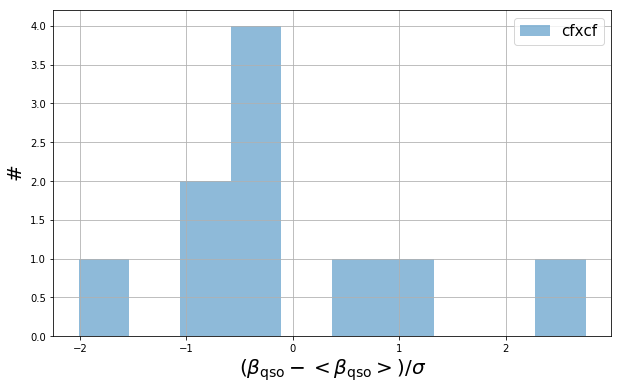

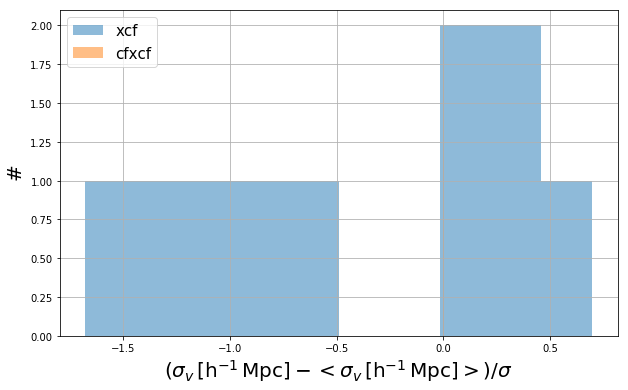

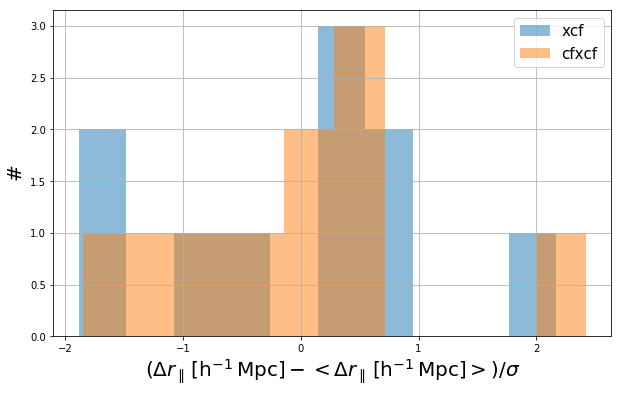

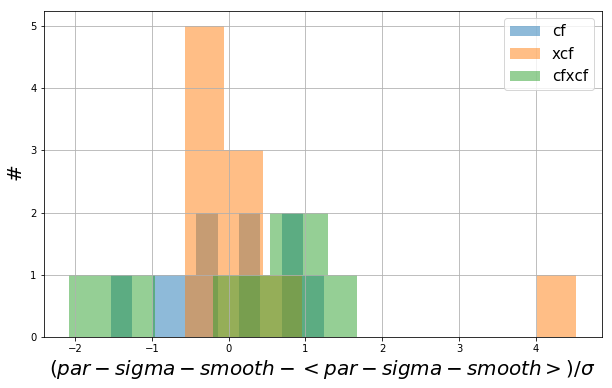

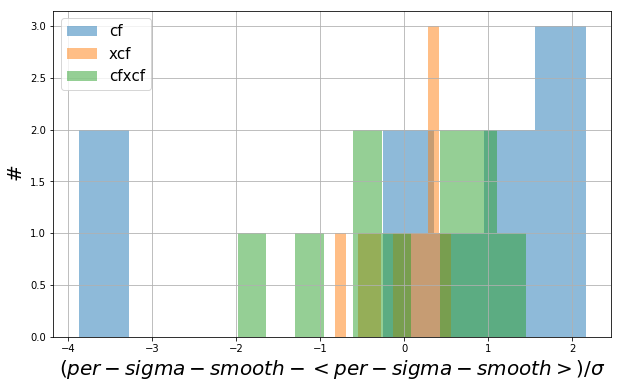

In [20]:
for p in latexname.keys():
    for zinterval in zint:
        zmin = zinterval.split(':')[0]
        zmax = zinterval.split(':')[1]
        for cor in ['cf','xcf','cfxcf']:
            xxx = 1.*sp.arange(mock['nbReal'])
            yyy = sp.zeros(mock['nbReal'])
            yer = sp.zeros(mock['nbReal'])
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p in toPlot[name]['FIT_RES']:
                    yyy[idx] = toPlot[name]['FIT_RES'][p][0]
                    yer[idx] = toPlot[name]['FIT_RES'][p][1]
            if cor=='xcf':
                xxx += 0.3
            w = yer>0.
            if w.sum()==0: continue
            plt.hist( (yyy[w]-yyy[w].mean())/yer[w] ,bins=10,alpha=0.5,label=cor)
    plt.xlabel(r'$('+latexname[p]+'-<'+latexname[p]+'>)/\sigma$')
    plt.ylabel(r'$\#$')
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

### Correlation between different parameters

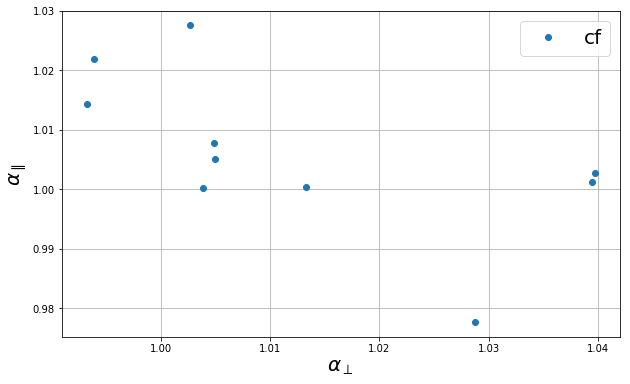

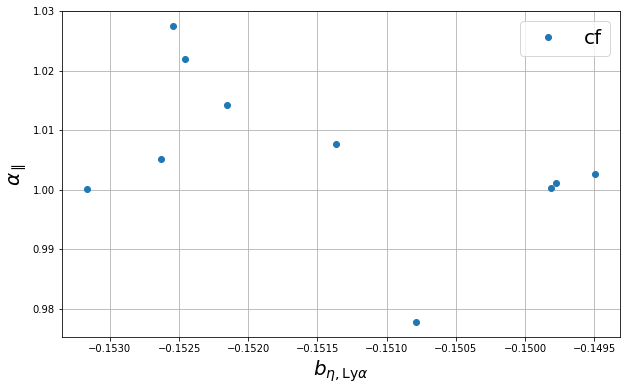

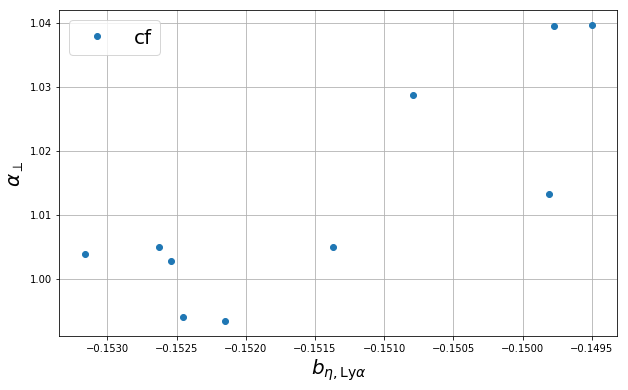

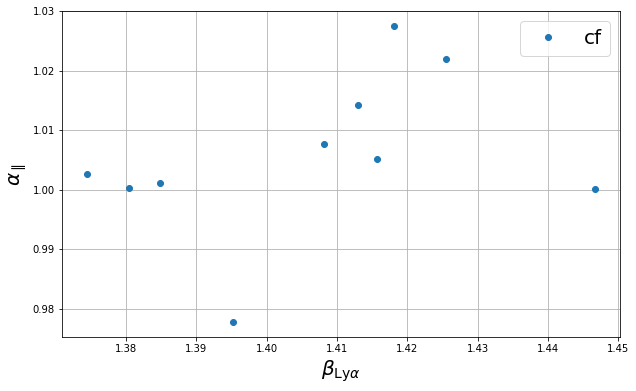

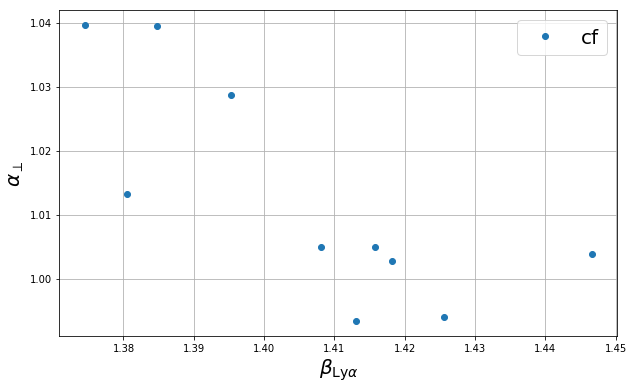

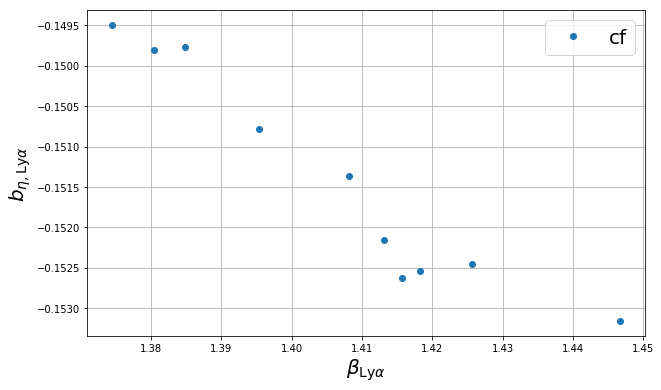

beta_QSO ap
beta_QSO at
beta_QSO bias_LYA
beta_QSO beta_LYA
sigma_velo_lorentz ap
sigma_velo_lorentz at
sigma_velo_lorentz bias_LYA
sigma_velo_lorentz beta_LYA
sigma_velo_lorentz beta_QSO
drp ap
drp at
drp bias_LYA
drp beta_LYA
drp beta_QSO
drp sigma_velo_lorentz


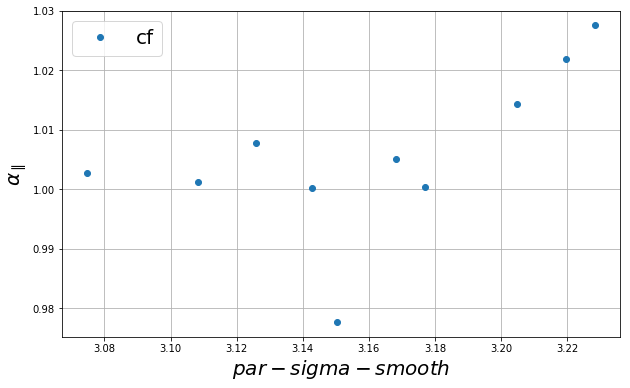

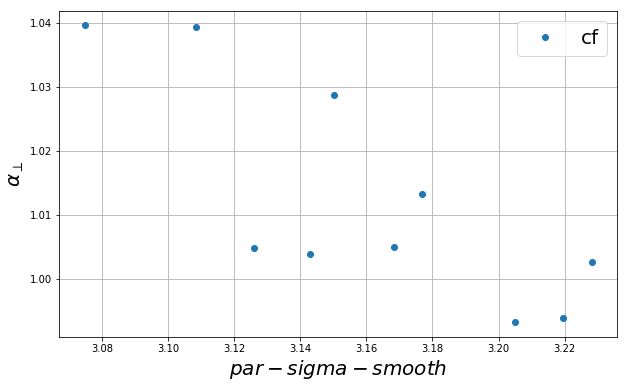

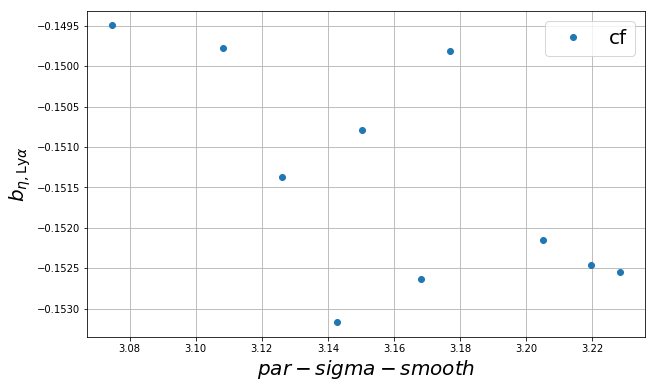

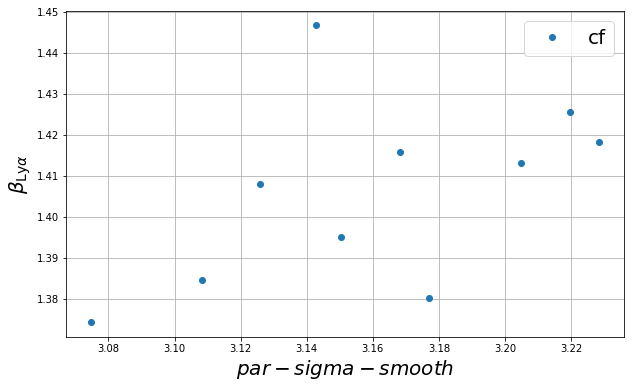

par_sigma_smooth beta_QSO
par_sigma_smooth sigma_velo_lorentz
par_sigma_smooth drp


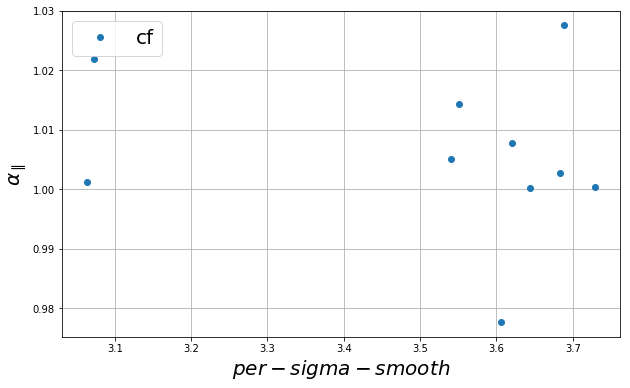

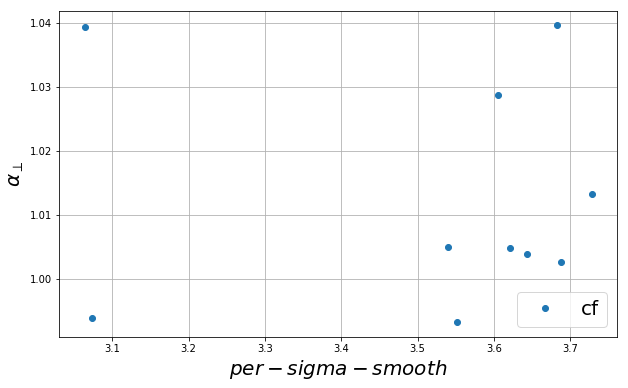

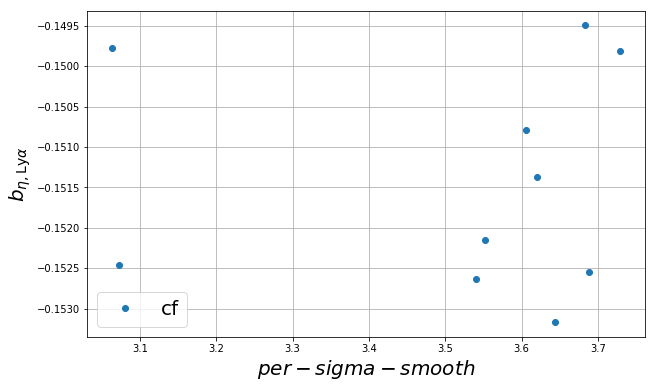

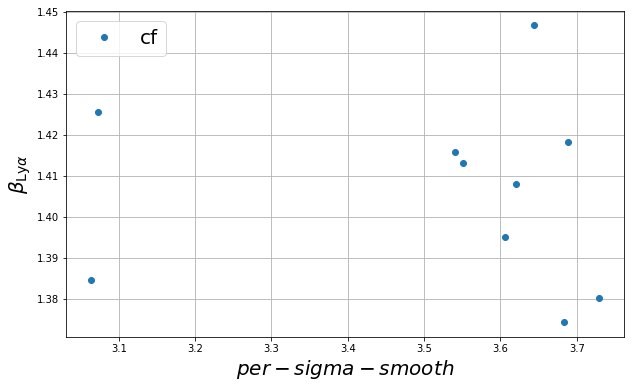

per_sigma_smooth beta_QSO
per_sigma_smooth sigma_velo_lorentz
per_sigma_smooth drp


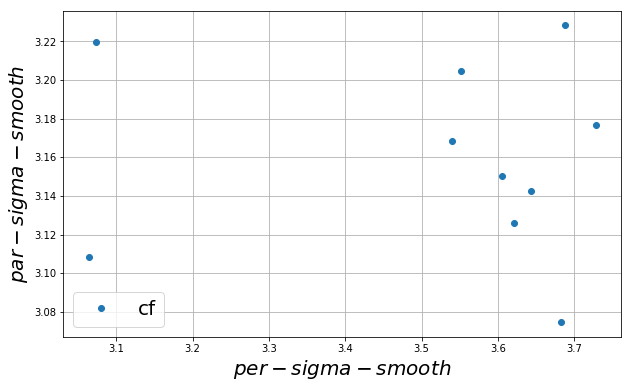

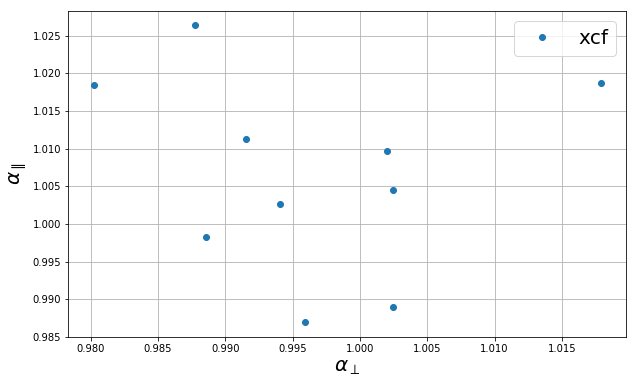

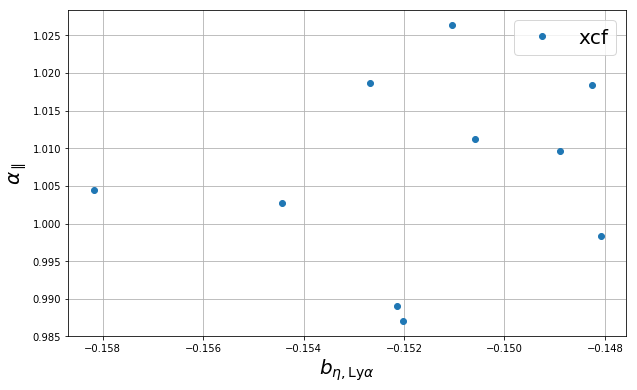

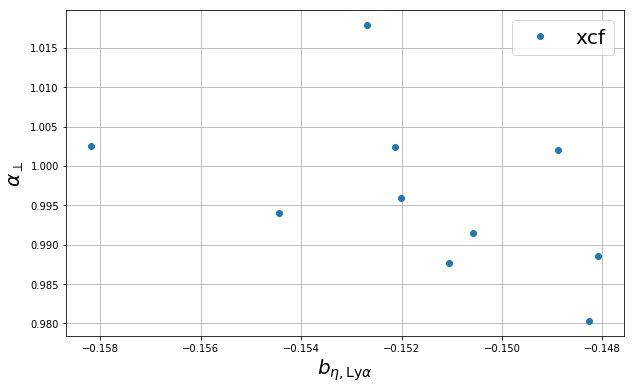

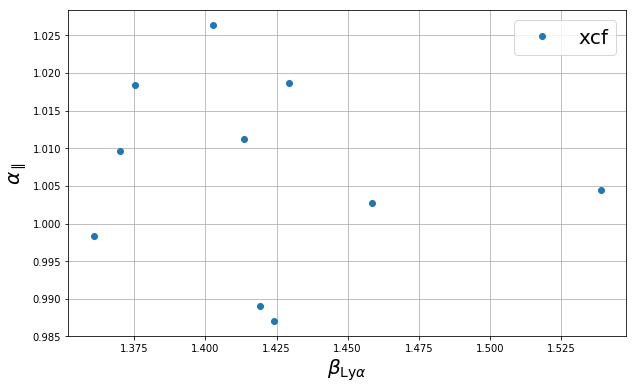

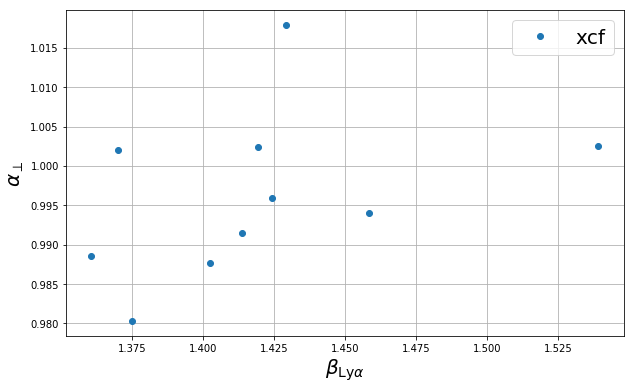

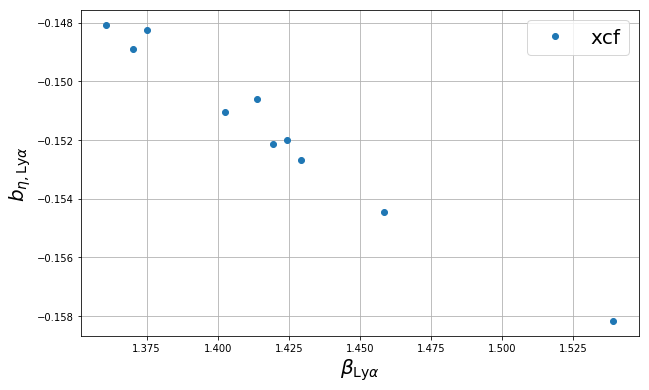

beta_QSO ap
beta_QSO at
beta_QSO bias_LYA
beta_QSO beta_LYA


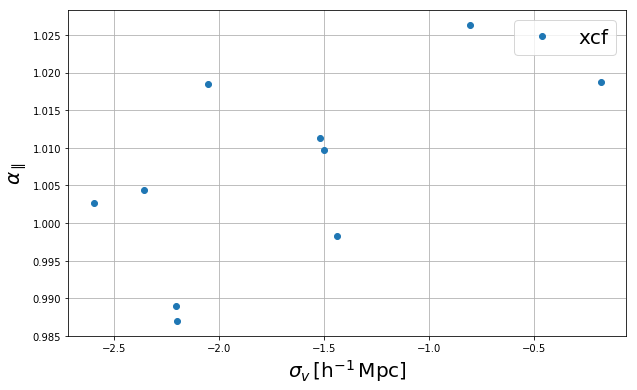

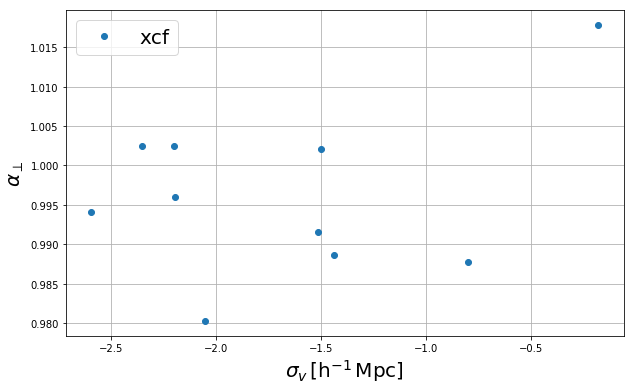

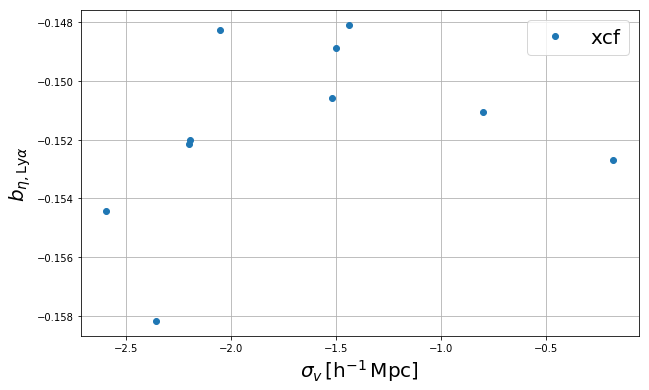

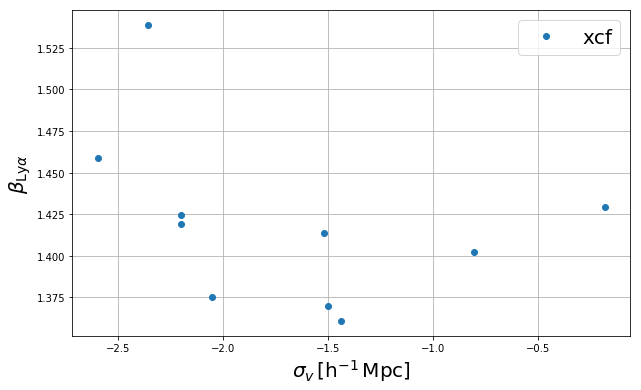

sigma_velo_lorentz beta_QSO


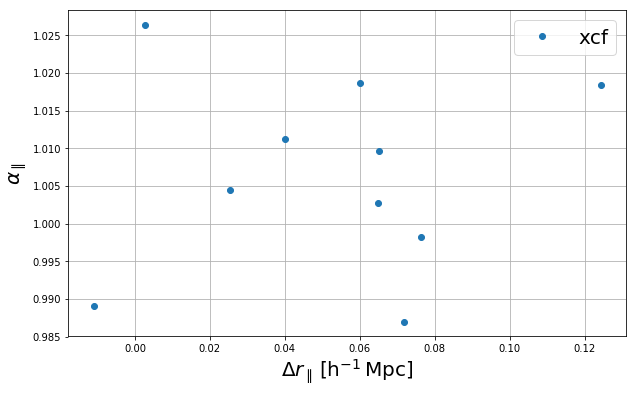

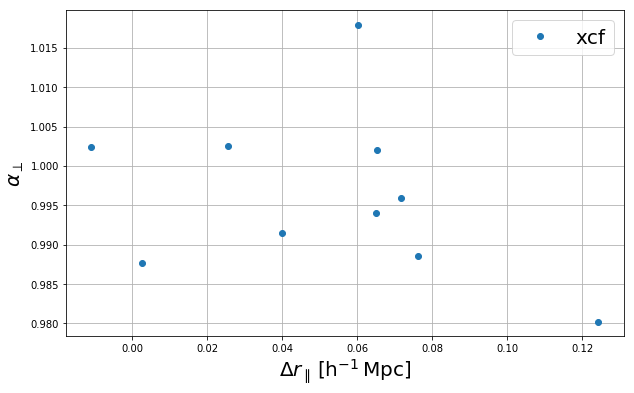

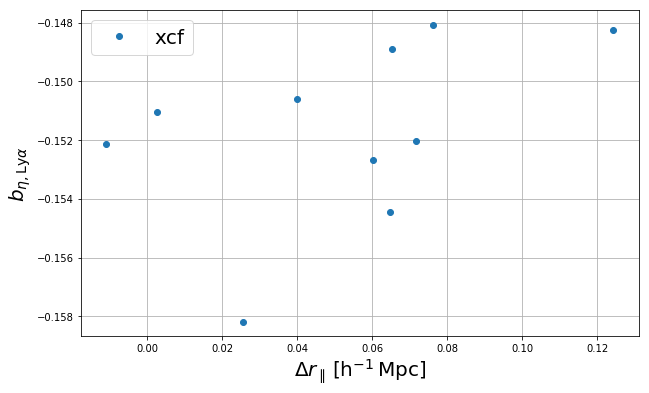

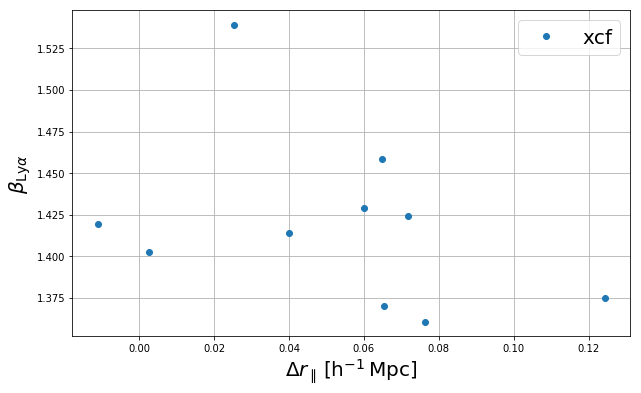

drp beta_QSO


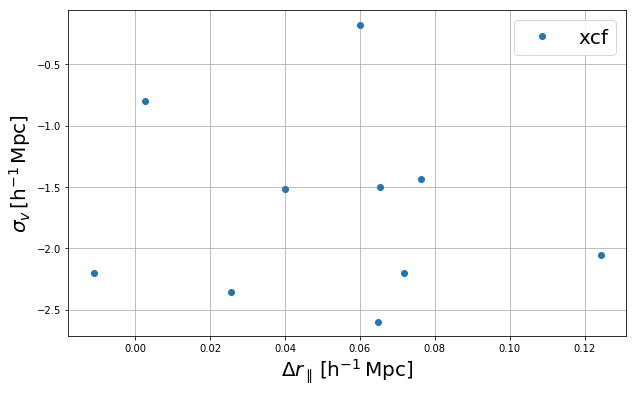

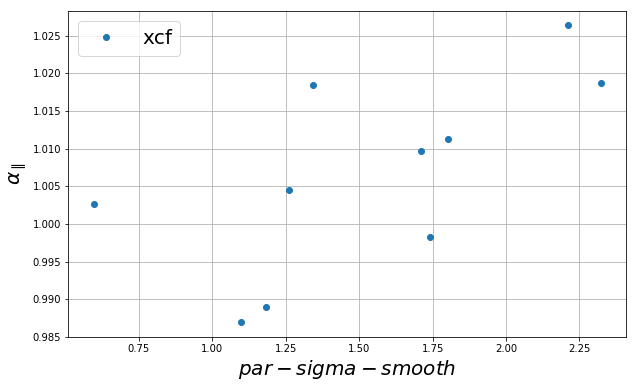

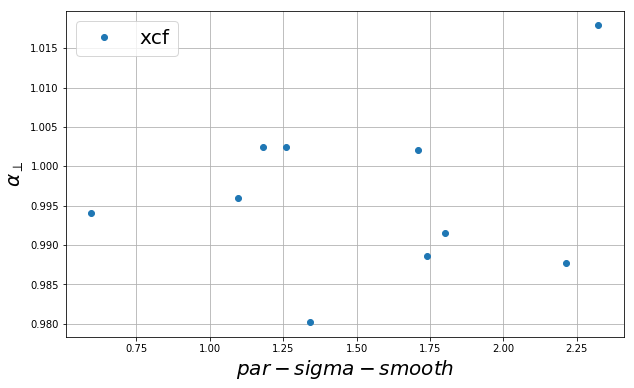

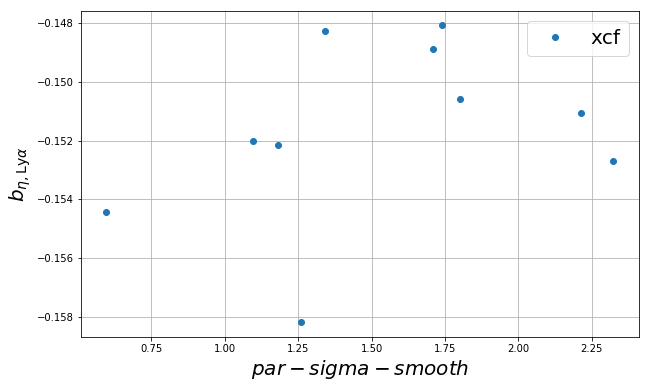

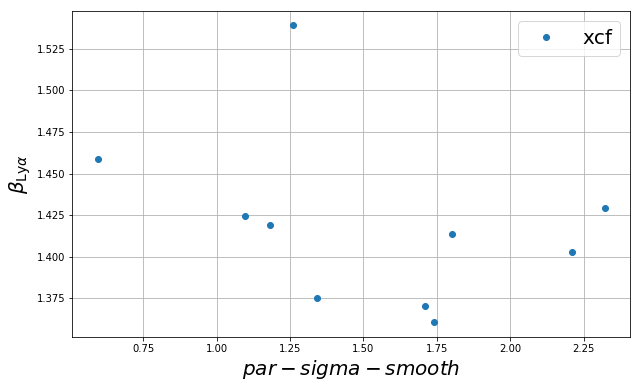

par_sigma_smooth beta_QSO


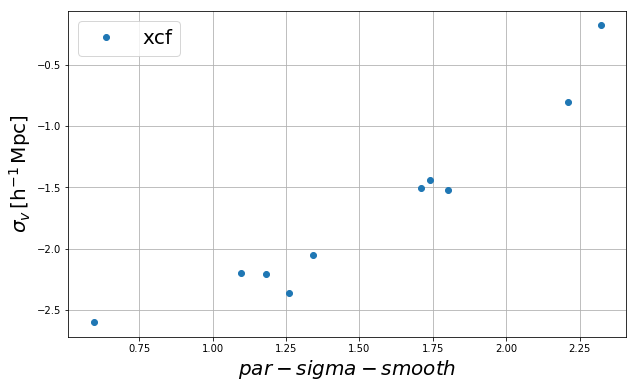

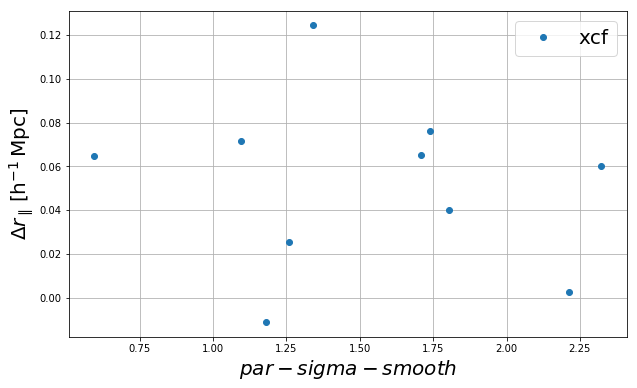

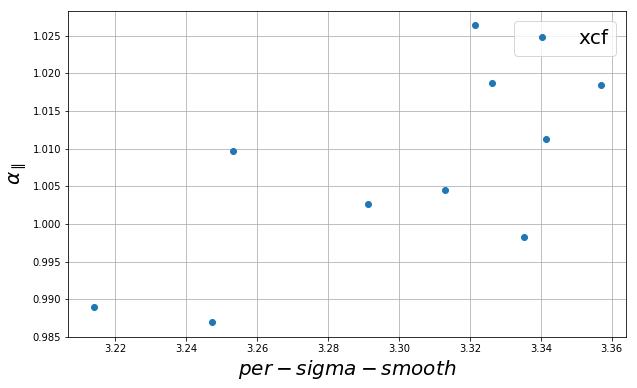

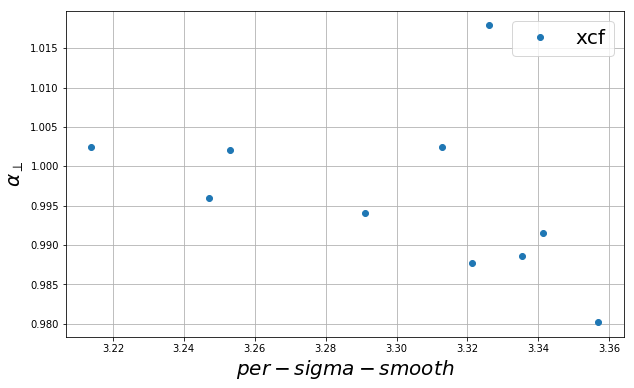

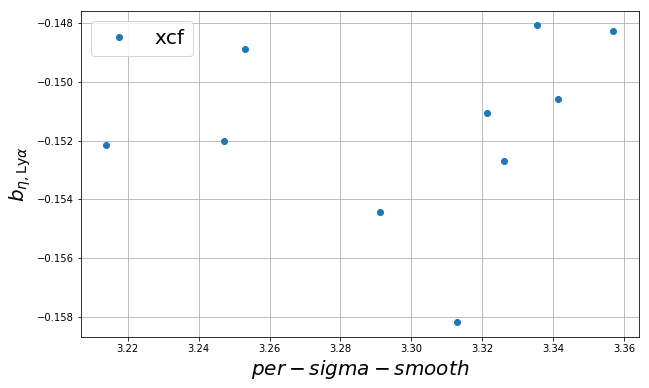

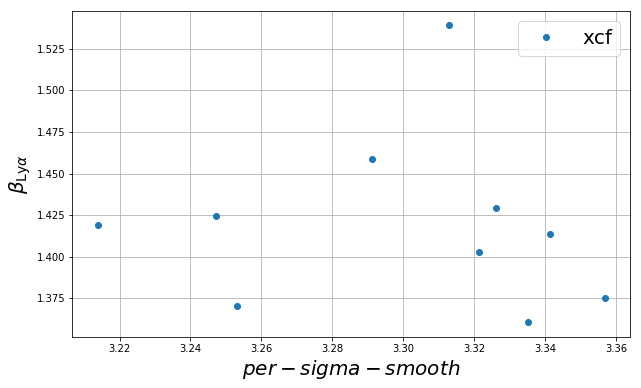

per_sigma_smooth beta_QSO


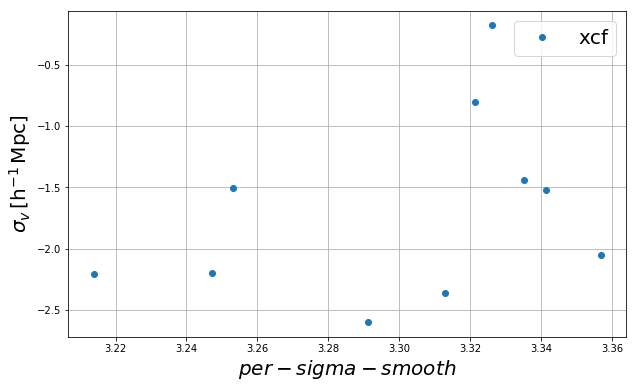

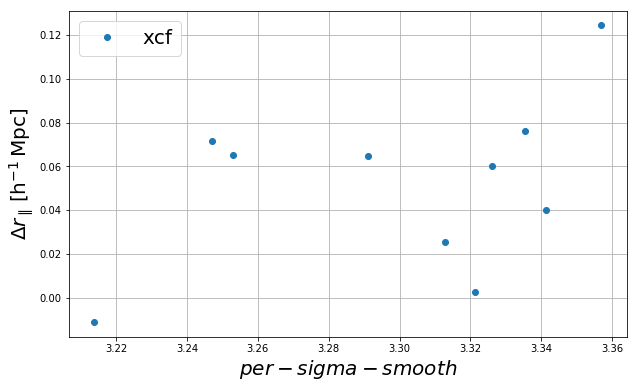

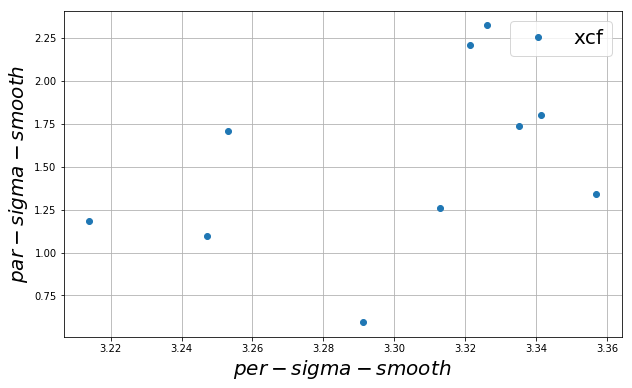

In [21]:
for zinterval in zint:
    zmin = zinterval.split(':')[0]
    zmax = zinterval.split(':')[1]

    for cor in ['cf','xcf']:
        for i,p1 in enumerate(list(latexname.keys())):
            yyy = sp.zeros( (mock['nbReal'],2))
            yer = sp.zeros( (mock['nbReal'],2))
            for idx in range(mock['nbReal']):
                name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                if 'FIT_RES' in toPlot[name] and p1 in toPlot[name]['FIT_RES']:
                    yyy[idx,0] = toPlot[name]['FIT_RES'][p1][0]
                    yer[idx,0] = toPlot[name]['FIT_RES'][p1][1]
            for p2 in list(latexname.keys())[:i]:
                if p1==p2: continue
                yyy[:,1] = 0.
                yer[:,1] = 0.
                for idx in range(mock['nbReal']):
                    name = '{}-Mock-{}-z-{}-{}'.format(idx,cor,zmin,zmax)
                    if 'FIT_RES' in toPlot[name] and p2 in toPlot[name]['FIT_RES']:
                        yyy[idx,1] = toPlot[name]['FIT_RES'][p2][0]
                        yer[idx,1] = toPlot[name]['FIT_RES'][p2][1]
                w = (yer[:,0]>0.) & (yer[:,1]>0.)
                if w.sum()==0:
                    print(p1,p2)
                    continue
                plt.errorbar(yyy[w,0], yyy[w,1], fmt='o',label=cor)
                plt.xlabel(r'$'+latexname[p1]+'$')
                plt.ylabel(r'$'+latexname[p2]+'$')
                plt.legend()
                plt.grid()
                plt.show()

## __Mean correlation__

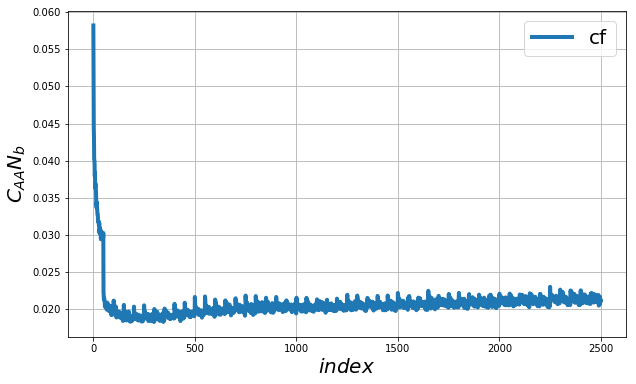

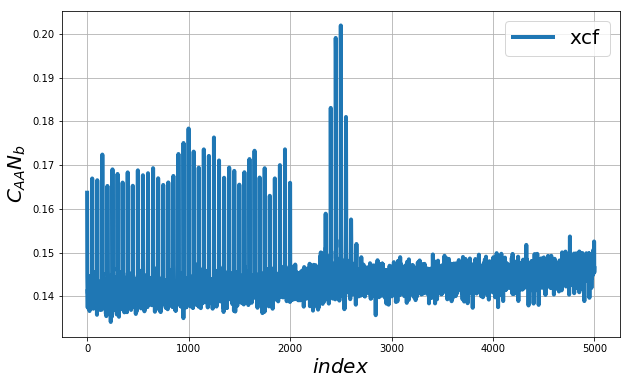

In [22]:
zmin = 0
zmax = 10
for cor in ['cf','xcf']:
    for idx in range(mock['nbReal']):
        tpath = mock['picca'].replace('<*>',str(idx))+'/{}_z_{}_{}-exp.fits'.format(cor,zmin,zmax)
        h = fitsio.FITS(tpath)
        if idx==0:
            co = h[1]['CO'][:].copy()
            nb = 1.*h[1]['NB'][:].copy()
        else:
            co += h[1]['CO'][:]
            nb += h[1]['NB'][:]
        h.close()
    co /= mock['nbReal']
    nb /= mock['nbReal']

    ###
    plt.plot(sp.diag(co)*nb,label=r'$\mathrm{'+cor+'}$')
    plt.xlabel(r'$index$')
    plt.ylabel(r'$C_{AA}N_{b}$')
    plt.legend()
    plt.grid()
    plt.show()

# Wedge plots

In [35]:
ttoPlot = {}

ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])

#ttoPlot['Std+BAObroadning'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
#ttoPlot['Std+BAObroadning']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Free_NLBroadening/cf_z_0_10-exp.h5'

#ttoPlot['Std+HCD'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
#ttoPlot['Std+HCD']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_HCD/cf_z_0_10-exp.h5'

#ttoPlot['Std+HCD+BAObroadning'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
#ttoPlot['Std+HCD+BAObroadning']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_HCD_Free_NLBroadening/cf_z_0_10-exp.h5'

ttoPlot['Std+GaussianSmoothing'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['Std+GaussianSmoothing']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_GaussianSmoothing/cf_z_0_10-exp.h5'

#ttoPlot['Std+GaussianSmoothing+BAObroadning'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
#ttoPlot['Std+GaussianSmoothing+BAObroadning']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_GaussianSmoothing_Free_NLBroadening/cf_z_0_10-exp.h5'

ttoPlot['Std+GaussianSmoothing+HCD'] = copy.deepcopy(toPlot['all-Mock-cf-z-0-10'])
ttoPlot['Std+GaussianSmoothing+HCD']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_GaussianSmoothing_Add_HCD/cf_z_0_10-exp.h5'


Std 3105.3005620945955 1590 6 0.0
Std+GaussianSmoothing 2020.0177939407386 1590 6 4.550804177938517e-13
Std+GaussianSmoothing+HCD 1699.5018739818775 1590 9 0.019286792119116436


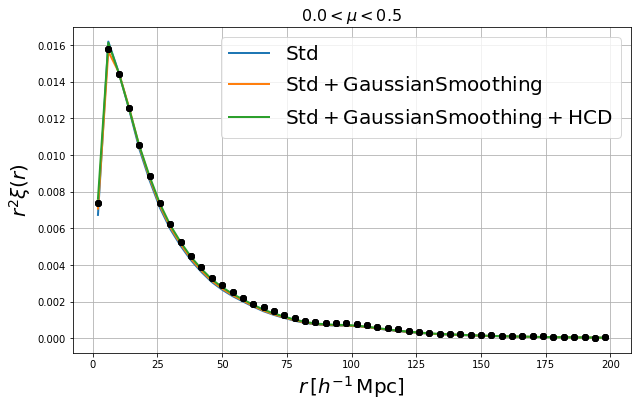

Std 3105.3005620945955 1590 6 0.0
Std+GaussianSmoothing 2020.0177939407386 1590 6 4.550804177938517e-13
Std+GaussianSmoothing+HCD 1699.5018739818775 1590 9 0.019286792119116436


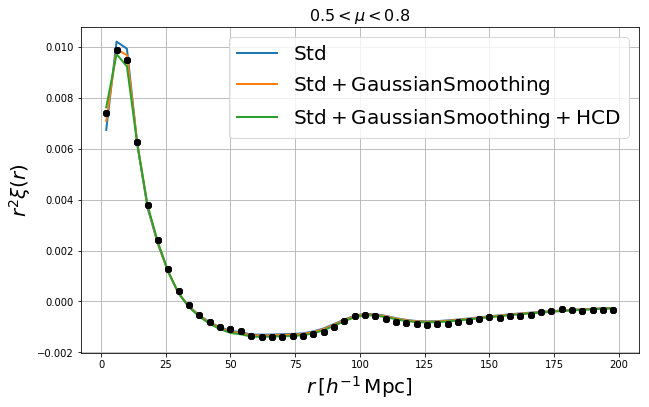

Std 3105.3005620945955 1590 6 0.0
Std+GaussianSmoothing 2020.0177939407386 1590 6 4.550804177938517e-13
Std+GaussianSmoothing+HCD 1699.5018739818775 1590 9 0.019286792119116436


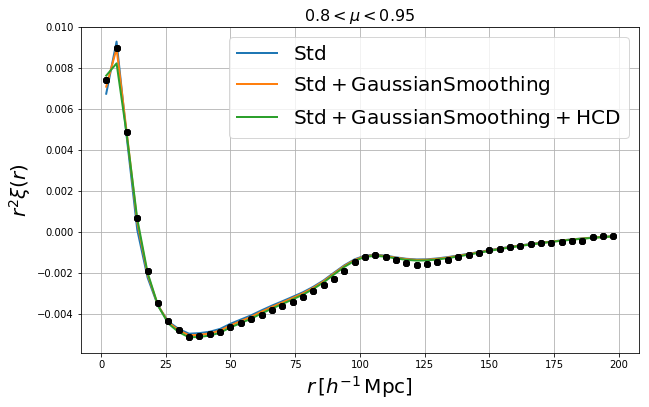

Std 3105.3005620945955 1590 6 0.0
Std+GaussianSmoothing 2020.0177939407386 1590 6 4.550804177938517e-13
Std+GaussianSmoothing+HCD 1699.5018739818775 1590 9 0.019286792119116436


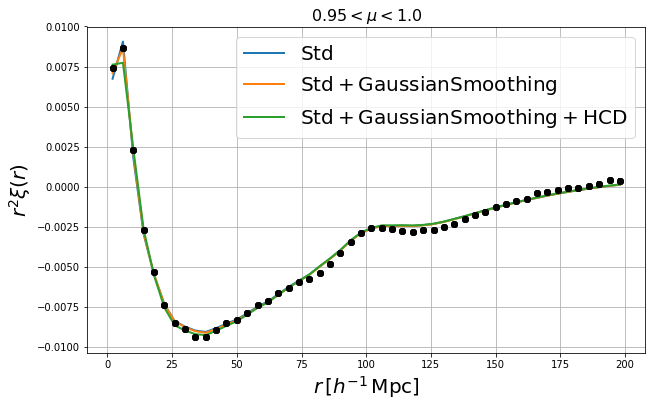

In [36]:
power = 1
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        p = 1.-sp.stats.chi2.cdf(ff['best fit'].attrs['fval'],ff['best fit'].attrs['ndata']-ff['best fit'].attrs['npar'])
        print(name,ff['best fit'].attrs['fval'],ff['best fit'].attrs['ndata'],ff['best fit'].attrs['npar'],p)
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",color='black')
        plt.plot(r,f*r**power,linewidth=2,label=r'$\mathrm{'+name+'}$')
    plt.ylabel(r"$r^2\xi(r)$")
    plt.xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

In [37]:
ttoPlot = {}
ttoPlot['Std'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])

#ttoPlot['Std+BAObroadning'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])
#ttoPlot['Std+BAObroadning']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Free_NLBroadening/xcf_z_0_10-exp.h5'

#ttoPlot['Std+freeGrowthRate'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])
#ttoPlot['Std+freeGrowthRate']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Free_growthrate/xcf_z_0_10-exp.h5'

#ttoPlot['Std+BAObroadning+freeGrowthRate'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])
#ttoPlot['Std+BAObroadning+freeGrowthRate']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Free_NLBroadening_Free_growthrate/xcf_z_0_10-exp.h5'

ttoPlot['Std+GaussianSmoothing'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])
ttoPlot['Std+GaussianSmoothing']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_GaussianSmoothing/xcf_z_0_10-exp.h5'

#ttoPlot['Std+GaussianSmoothing+BAObroadning'] = copy.deepcopy(toPlot['all-Mock-xcf-z-0-10'])
#ttoPlot['Std+GaussianSmoothing+BAObroadning']['FIT'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0.all/quick-2.0/Tests_model/Add_GaussianSmoothing_Free_NLBroadening/xcf_z_0_10-exp.h5'


Std 3508.637512378097 3180 9 2.010651619777093e-05
Std+GaussianSmoothing 3413.4362655157283 3180 9 0.001449250981470973


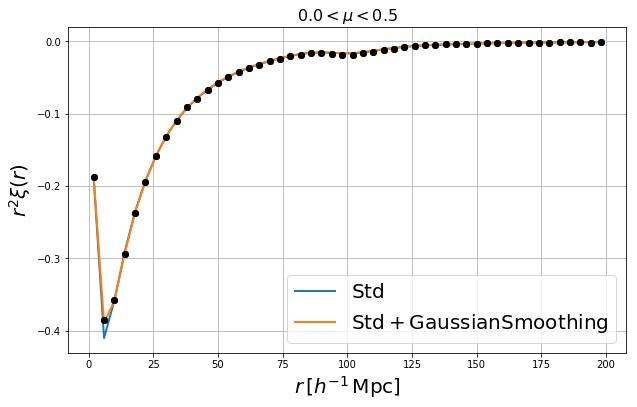

Std 3508.637512378097 3180 9 2.010651619777093e-05
Std+GaussianSmoothing 3413.4362655157283 3180 9 0.001449250981470973


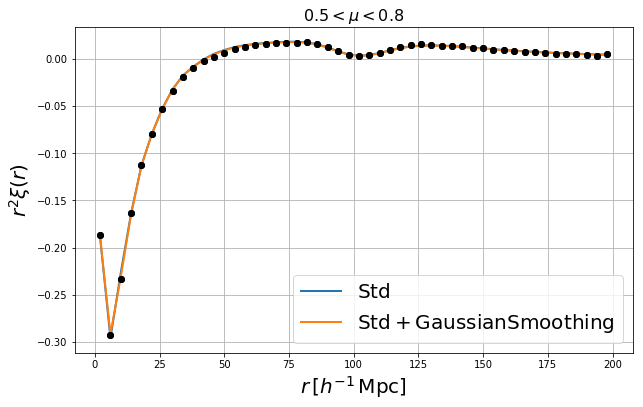

Std 3508.637512378097 3180 9 2.010651619777093e-05
Std+GaussianSmoothing 3413.4362655157283 3180 9 0.001449250981470973


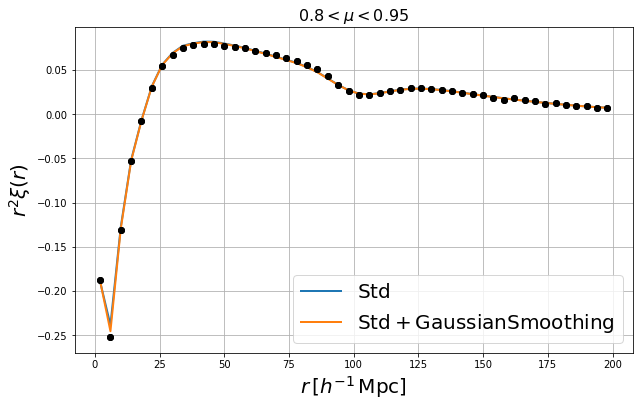

Std 3508.637512378097 3180 9 2.010651619777093e-05
Std+GaussianSmoothing 3413.4362655157283 3180 9 0.001449250981470973


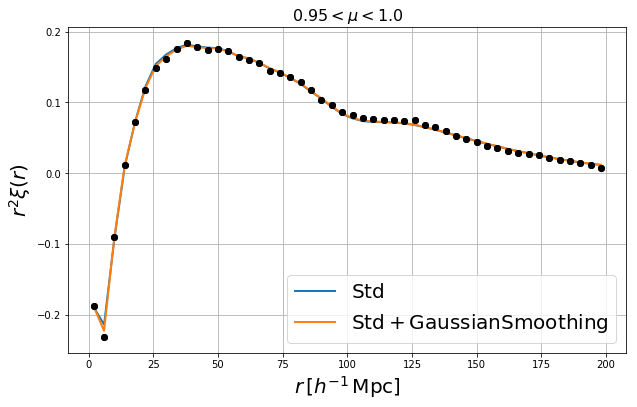

In [38]:
power = 1
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        p = 1.-sp.stats.chi2.cdf(ff['best fit'].attrs['fval'],ff['best fit'].attrs['ndata']-ff['best fit'].attrs['npar'])
        print(name,ff['best fit'].attrs['fval'],ff['best fit'].attrs['ndata'],ff['best fit'].attrs['npar'],p)
        fit = ff[paths['NAME']+'/fit'][...]
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        rpmin = h[1].read_header()['RPMIN']
        np = h[1].read_header()['NP']
        h.close()
        ff.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        plt.errorbar(r,d*r**power,yerr=sp.sqrt(c.diagonal())*r**power,fmt="o",color='black')
        plt.plot(r,f*r**power,linewidth=2,label=r'$\mathrm{'+name+'}$')
    plt.ylabel(r"$r^2\xi(r)$")
    plt.xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

# Slice plots

In [39]:
ttoPlot = {}
ttoPlot['Mock'] = toPlot['all-Mock-xcf-z-0-10']

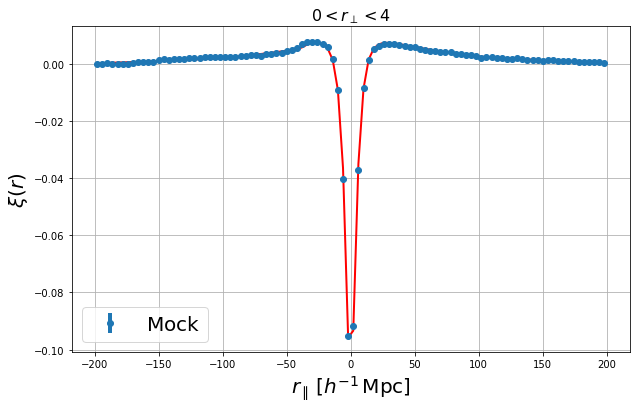

In [40]:
slices = [0]
for s in slices:
    for name,paths in sorted(ttoPlot.items()):
        h = fitsio.FITS(paths['CORR'])
        ff = h5py.File(paths['FIT'],'r')
        fit = ff[paths['NAME']+'/fit'][...]
        rp = h[1]['RP'][:]
        rt = h[1]['RT'][:]
        drt = h[1].read_header()['RTMAX'] / h[1].read_header()['NT']
        da = h[1]['DA'][:]
        er = sp.sqrt(sp.diag(h[1]['CO'][:]))
        h.close()
        ff.close()
        w = (rt>=s*drt) & (rt<(s+1)*drt)
        rp = rp[w]
        da = da[w]
        fit = fit[w]
        er = er[w]
        plt.errorbar(rp,da,yerr=er,fmt="o",label=r'$\mathrm{'+name+'}$')
        plt.plot(rp,fit,color='red',linewidth=2)
        ff.close()
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r_{\parallel} \, [h^{-1}\, \mathrm{Mpc}]$")
    plt.title(r"${}<r_\perp<{}$".format(int(s*drt),int((s+1)*drt)),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()